# Analytics - query to reference mapping  

This notebook is based on and adapted from this scvi-tools tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/query_hlca_knn.html

In [1]:
import scvi
import mplscience
import matplotlib.pyplot as plt
import os
import pynndescent
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scvi.data._download import _download
import anndata

scvi.settings.seed = 1

# plotting commands for the styling
mplscience.set_style(reset_current=True, name="default")

%load_ext autoreload
%autoreload 2

/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/cupy/_environment.py:447: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
Global seed set to 1


## Citations

scArches:  
Mohammad Lotfollahi, Mohsen Naghipourfar, Malte D. Luecken, Matin Khajavi, Maren Büttner, Marco Wagenstetter, Žiga Avsec, Adam Gayoso, Nir Yosef, Marta Interlandi, Sergei Rybakov, Alexander V. Misharin, and Fabian J. Theis. Mapping single-cell data to reference atlases by transfer learning. Nature Biotechnology, 40(1):121–130, August 2021. doi:10.1038/s41587-021-01001-7.  

scANVI:  
Chenling Xu, Romain Lopez, Edouard Mehlman, Jeffrey Regier, Michael I Jordan, and Nir Yosef. Probabilistic harmonization and annotation of single-cell transcriptomics data with deep generative models. Molecular Systems Biology, January 2021. doi:10.15252/msb.20209620.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

## 1️⃣ Download the pre-trained model

Here we use the HLCA dataset.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

Let's download the pre-trained model

In [2]:
local_dir = "/home/cane/Documents/yoseflab/can/scvi-hub"

In [3]:
model_url = "https://huggingface.co/scvi-tools/human-lung-cell-atlas/resolve/main/model.pt"
scvi.data._download._download(model_url, local_dir, "model.pt")

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               


## 2️⃣ Download the query data

For the query, we will use samples from the following publication:  

- Delorey, Toni M., et al. “COVID-19 tissue atlases reveal SARS-CoV-2 pathology and cellular targets.” Nature 595.7865 (2021): 107-113.

In [4]:
from scvi.data import cellxgene
adata_url = "https://cellxgene.cziscience.com/e/ae29ebd0-1973-40a4-a6af-d15a5f77a80f.cxg/"
query_data = cellxgene(adata_url, filename="pan_immune_cells.h5ad", save_path=local_dir)

In [5]:
query_data = query_data[query_data.obs['tissue'] == 'lung']

In [6]:
# add dataset information:
query_data.obs['dataset'] = "pan_immune_cell"

/tmp/ipykernel_2017317/455780152.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  query_data.obs['dataset'] = "pan_immune_cell"


In [7]:
query_data

AnnData object with n_obs × n_vars = 8852 × 36503
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'dataset'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'sex_ontology_term_id_colors', 'title'
    obsm: 'X_umap'

## 3️⃣ Build a query model

Use `prepare_query_anndata` to re-order the genes and pad any missing genes with 0s, so that query_adata matches exactly the reference in terms of its gene set.  

In [8]:
scvi.model.SCANVI.prepare_query_anndata(query_data, local_dir)

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               
INFO     Found 99.55000000000001% reference vars in query data.                                                    


/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [9]:
query_data.obs["scanvi_label"] = "unlabeled"

In [10]:
query_model = scvi.model.SCANVI.load_query_data(query_data, local_dir, accelerator = "cpu")

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [11]:
query_model.adata

AnnData object with n_obs × n_vars = 8852 × 2000
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_umap'

Train the query model.

In [12]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [13]:
query_model.train(
    max_epochs=surgery_epochs,
    accelerator="cpu",
    **train_kwargs_surgery,
)

INFO     Training for 500 epochs.                                                                                  


/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/torch/cuda/__init__.py:651: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 129/500:  26%|██▌       | 129/500 [40:59<1:57:52, 19.06s/it, v_num=1, train_loss_step=543, train_loss_epoch=539]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 607.126. Signaling Trainer to stop.


In [14]:
query_save_path = f"{local_dir}/query_model_pan_immune"
query_model.save(query_save_path, overwrite=True)

In [15]:
query_data.obsm['X_scanvi_emb'] = query_model.get_latent_representation()

## 4️⃣ Learn a neighbors index on reference latent space  

Get the "latent space" from our embeddings for extended data set. It is essentially just the mean of the latent distribution.

In [17]:
from scvi.data import cellxgene

adata_url = "https://cellxgene.cziscience.com/e/9f222629-9e39-47d0-b83f-e08d610c7479.cxg/"
adata = cellxgene(adata_url, filename="adata_extended2.h5ad", save_path=local_dir)

In [18]:
adata

AnnData object with n_obs × n_vars = 2282447 × 56295
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 

In [19]:
ref = adata.obsm['X_scanvi_emb']
ref_nn_index = pynndescent.NNDescent(ref)
ref_nn_index.prepare()

## 5️⃣ Predict cell types

Let's predict using a different cell type than we did earlier, as that is too coarse grained (compartment-level resolution).

In [20]:
ref_neighbors, ref_distances = ref_nn_index.query(query_data.obsm['X_scanvi_emb'])

In [21]:
def distances_to_affinities(distances):
    # convert distances to affinities
    stds = np.std(distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)
    distances_tilda = np.exp(-np.true_divide(distances, stds))
    weights = distances_tilda / np.sum(
        distances_tilda, axis=1, keepdims=True
    )
    return weights

# import numba
# @numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

weights = distances_to_affinities(ref_distances)

### Predict

In [22]:
label_key = "ann_level_3"
ref_cats = adata.obs[label_key].cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(adata.obs[label_key].cat.categories)[p]
query_data.obs["celltype_pred"], query_data.obs["celltype_uncertainty"] = p, u

### Evaluate predictions

Finally, let's evaluate predictions.

In [23]:
query_data.obs[["celltype_pred", "celltype_uncertainty"]]

celltype_pred  celltype_uncertainty
Pan_T7935492_AAACCTGAGGCTACGA           T cell lineage          4.999837e-01
Pan_T7935492_AAACCTGTCGGTTAAC  Innate lymphoid cell NK          9.999937e-02
Pan_T7935492_AAACGGGAGGTGTTAA           T cell lineage          0.000000e+00
Pan_T7935492_AAACGGGGTCCGACGT           T cell lineage          0.000000e+00
Pan_T7935492_AAAGATGAGTGTCCAT  Innate lymphoid cell NK          0.000000e+00
...                                                ...                   ...
CZINY-0112_TTCGGTCCATCGAGCC             T cell lineage          5.960464e-08
CZINY-0112_TTGAACGCATACCAGT    Innate lymphoid cell NK          3.999982e-01
CZINY-0112_TTGCGTCAGCCTGGAA             T cell lineage          0.000000e+00
CZINY-0112_TTGTTCACAGTAACAA    Innate lymphoid cell NK          3.000008e-01
CZINY-0112_TTTGGTTTCCATCACC             T cell lineage          0.000000e+00

[8852 rows x 2 columns]

0.045006492903638735 5.960464477539063e-08


<Axes: ylabel='Density'>

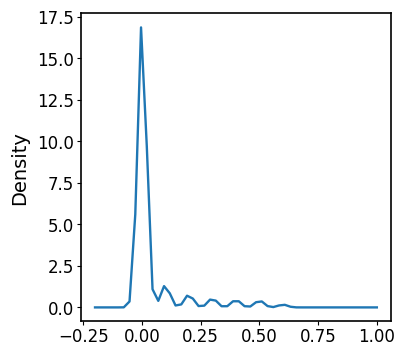

In [24]:
print(query_data.obs["celltype_uncertainty"].mean(), np.quantile(query_data.obs["celltype_uncertainty"], 0.75))
query_data.obs["celltype_uncertainty"].plot(kind='density', ind=np.linspace(-0.2, 1))

In [25]:
def get_comparison_df(uncertainty_threshold = None):
    # build comparison_df
    comparison_df = pd.DataFrame(index=query_data.obs_names, columns=["pred", "ground_truth", "pred_uncertainty"])
    comparison_df["pred"] = query_data.obs["celltype_pred"]
    comparison_df["pred_uncertainty"] = query_data.obs["celltype_uncertainty"]
    comparison_df["ground_truth"] = query_data.obs["Manually_curated_celltype"].fillna("Unknown")

    # we dont care about cases where we dont know the ground truth (in fact we could have skipped prediction for these altogether)
    n_before = len(comparison_df)
    comparison_df = comparison_df[comparison_df["ground_truth"] != "Unknown"]
    n_filtered = n_before-len(comparison_df)
    pct_filtered = 100*n_filtered/n_before
    print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with unknown ground truth")

    if uncertainty_threshold is not None:
        # filter out uncertainty > threshold
        n_before = len(comparison_df)
        comparison_df = comparison_df[comparison_df["pred_uncertainty"] <= uncertainty_threshold]
        n_filtered = n_before-len(comparison_df)
        pct_filtered = 100*n_filtered/n_before
        print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with pred uncertainty < {uncertainty_threshold}")

    return comparison_df

In [26]:
comparison_df = get_comparison_df(uncertainty_threshold=0.2)

filtered out 0 barcodes (0.00%) with unknown ground truth
filtered out 790 barcodes (8.92%) with pred uncertainty < 0.2


## 6️⃣ Plot
Let's plot heatmap

In [27]:
temp_fig_dir = "/home/cane/Documents/yoseflab/can/scvi-hub/query_ref/"

In [28]:
comparison_df

pred  ground_truth  \
Pan_T7935492_AAACCTGTCGGTTAAC  Innate lymphoid cell NK      NK_CD16+   
Pan_T7935492_AAACGGGAGGTGTTAA           T cell lineage  Tem/emra_CD8   
Pan_T7935492_AAACGGGGTCCGACGT           T cell lineage  Trm_Th1/Th17   
Pan_T7935492_AAAGATGAGTGTCCAT  Innate lymphoid cell NK  Cycling T&NK   
Pan_T7935492_AAAGCAAAGAGCTGGT           T cell lineage    Trm/em_CD8   
...                                                ...           ...   
CZINY-0112_TTATTGCGTTATAGAG    Innate lymphoid cell NK      NK_CD16+   
CZINY-0112_TTCCAATGTATCGTGT    Innate lymphoid cell NK      NK_CD16+   
CZINY-0112_TTCGGTCCATCGAGCC             T cell lineage    Tgd_CRTAM+   
CZINY-0112_TTGCGTCAGCCTGGAA             T cell lineage      NK_CD16+   
CZINY-0112_TTTGGTTTCCATCACC             T cell lineage  Tem/emra_CD8   

                               pred_uncertainty  
Pan_T7935492_AAACCTGTCGGTTAAC      9.999937e-02  
Pan_T7935492_AAACGGGAGGTGTTAA      0.000000e+00  
Pan_T7935492_AAACGGGGTCCGACGT      0.000000e+00  
Pan_T7935492_AAAGATGAGTGTCCAT      0.000000e+00  
Pan_T7935492_AAAGCAAAGAGCTGGT      0.000000e+00  
...                                         ...  
CZINY-0112_TTATTGCGTTATAGAG        9.999764e-02  
CZINY-0112_TTCCAATGTATCGTGT        9.999830e-02  
CZINY-0112_TTCGGTCCATCGAGCC        5.960464e-08  
CZINY-0112_TTGCGTCAGCCTGGAA        0.000000e+00  
CZINY-0112_TTTGGTTTCCATCACC        0.000000e+00  

[8062 rows x 3 columns]

In [29]:
comparison_df["pred"].value_counts()

T cell lineage             5471
Innate lymphoid cell NK    2585
Multiciliated lineage         3
Mast cells                    2
Unknown                       1
Name: pred, dtype: int64

In [30]:
comparison_df.groupby("pred")["pred_uncertainty"].mean()

pred
Innate lymphoid cell NK    0.027968
Mast cells                 0.149977
Multiciliated lineage      0.000000
T cell lineage             0.004569
Unknown                    0.199996
Name: pred_uncertainty, dtype: float64

In [31]:
comparison_df = comparison_df.loc[comparison_df["pred"].isin(["T cell lineage", "Innate lymphoid cell NK"])]
comparison_df["pred"].value_counts()

T cell lineage             5471
Innate lymphoid cell NK    2585
Name: pred, dtype: int64

Some notes on the new HLCA annotations (https://zenodo.org/record/6337966/ vs https://zenodo.org/record/7599104):
- All new 60 cells have None for ann_level_3 annotations.
- No cells was predicted as "Smooth muscle FAM83D+" (even before thresholding on prediction uncertainty)
- In prev ann_level_3, not in new: 'Fibromyocytes'
- In new ann_level_3, not in prev: 'Smooth muscle FAM83D+'
- Only 565 cells differ between prev and new ann_level_3 annotations and their distribution is (prev, new):  
Fibromyocytes,Smooth muscle FAM83D+   -> 335  
Secretory,AT2                       ->   230

In [32]:
# https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cellassign_tutorial.html#Model-reproducibility
confusion_matrix = pd.crosstab(
    comparison_df["pred"],
    comparison_df["ground_truth"], 
    rownames=["Predicted label"],
    colnames=["True label"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
confusion_matrix *= 100

<Axes: xlabel='True label', ylabel='Predicted label'>

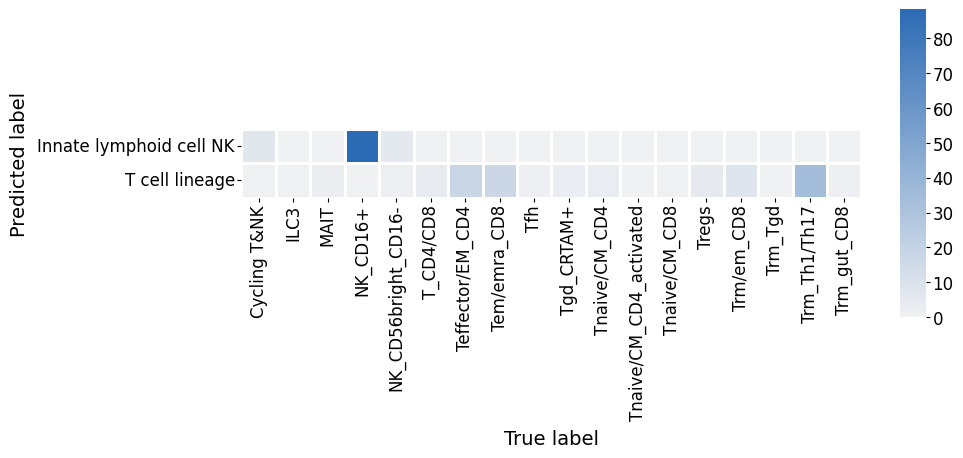

In [33]:
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    confusion_matrix,
    # cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    ax=ax,
    square=True,
    fmt=".2f",
    cbar_kws=dict(shrink=0.4, aspect=12),
    linecolor='white',
    linewidths=1, 
    # annot=True,
    # norm=LogNorm()
)

## 7️⃣ Visualize embeddings in the joint latent space

Combine embeddings

In [34]:
query_data.obs["dataset"] = "pan_immune"
query_data

AnnData object with n_obs × n_vars = 8852 × 2000
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels', 'celltype_pred', 'celltype_uncertainty'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_umap', 'X_scanvi_emb'

In [35]:
adata

AnnData object with n_obs × n_vars = 2282447 × 56295
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 

In [36]:
combined_data = adata.concatenate(query_data)

/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


# Visualize embeddings

Visualize embeddings.

I do this on a device with more ram, but you can run it locally if you have enough ram.

In [37]:
combined_data.var['feature_is_filtered-1'] = combined_data.var['feature_is_filtered-1'].astype("category")

In [38]:
combined_data.write_h5ad(f"{local_dir}/combined_data_extended.h5ad")

import scanpy as sc
import anndata
combined_data = anndata.read_h5ad(f"{local_dir}/combined_data_extended.h5ad")

In [39]:
sc.pp.neighbors(combined_data, use_rep="X_scanvi_emb", method='rapids')
sc.tl.umap(combined_data, min_dist=0.3, method='rapids')
combined_data.write_h5ad(f"{local_dir}/combined_data_extended.h5ad")

#combined_emb_umap = anndata.read_h5ad(f"{local_dir}/combined_emb_umap.h5ad")

CUDARuntimeError: cudaErrorCompatNotSupportedOnDevice: forward compatibility was attempted on non supported HW

In [ ]:
import scanpy as sc
import anndata
combined_data = sc.read_h5ad(f"{local_dir}/combined_data_extended.h5ad")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/cane/Documents/yoseflab/can/scvi-hub/combined_data_extended.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


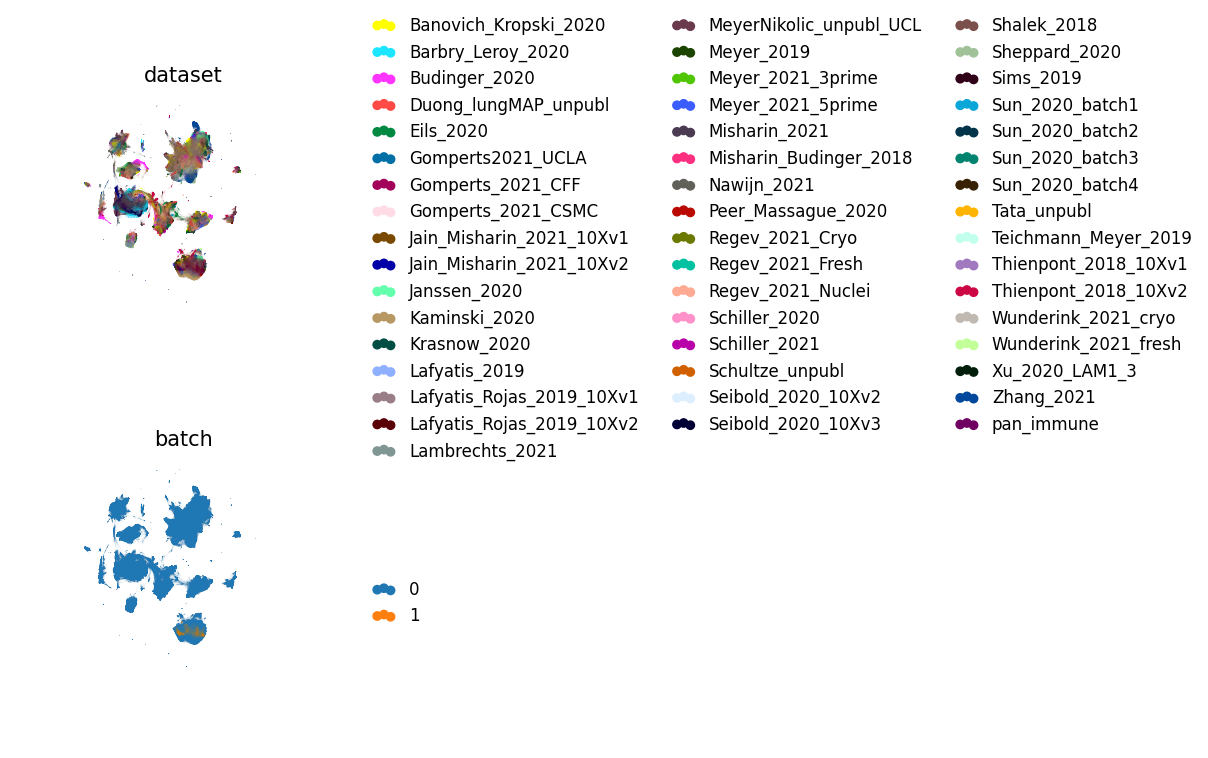

In [ ]:
sc.pl.umap(
    combined_data,
    color=["dataset", "batch"],
    ncols=1,
    frameon=False,
)

Let's plot only batch. It is 1:1 equivalent with the dataset anyway as can be seen below.

In [ ]:
idx1 = combined_data.obs["batch"] == "1"
idx2 = combined_data.obs["dataset"] == "pan_immune"
assert idx1.equals(idx2)

In [40]:
sc.set_figure_params(vector_friendly=True, dpi_save=300)

In [41]:
df = combined_data.obs
default_size = 120000 / len(df) # default scanpy
df["umap_size"] = default_size * 10
df.loc[df["batch"] == "1", "umap_size"] = default_size * 10 # if you want to make the query dataset points bigger
combined_data.obs = df

/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


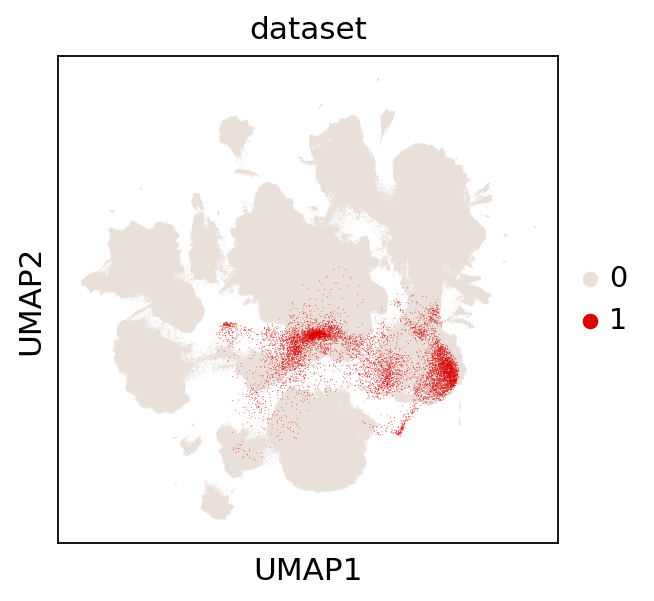

In [42]:
custom_pal = {"0": "#EAE0DA", "1": "#DC0000"}
sc.pl.umap(
    combined_data,
    color=["batch"],
    ncols=1,
    frameon=True,
    save="combined_umap_batch_panimmune.svg",
    palette=custom_pal,
    size=combined_data.obs["umap_size"],
    title="dataset"
)

In [43]:
combined_data.obs['Manually_curated_celltype'].value_counts()

NK_CD16+                   2771
Trm_Th1/Th17               1876
Teffector/EM_CD4            947
Tem/emra_CD8                945
NK_CD56bright_CD16-         462
Trm/em_CD8                  417
Tregs                       256
T_CD4/CD8                   248
Cycling T&NK                216
Tnaive/CM_CD4               176
Tgd_CRTAM+                  148
MAIT                        124
Trm_gut_CD8                  82
Tfh                          79
ILC3                         40
Tnaive/CM_CD8                39
Trm_Tgd                      17
Tnaive/CM_CD4_activated       9
Name: Manually_curated_celltype, dtype: int64

/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


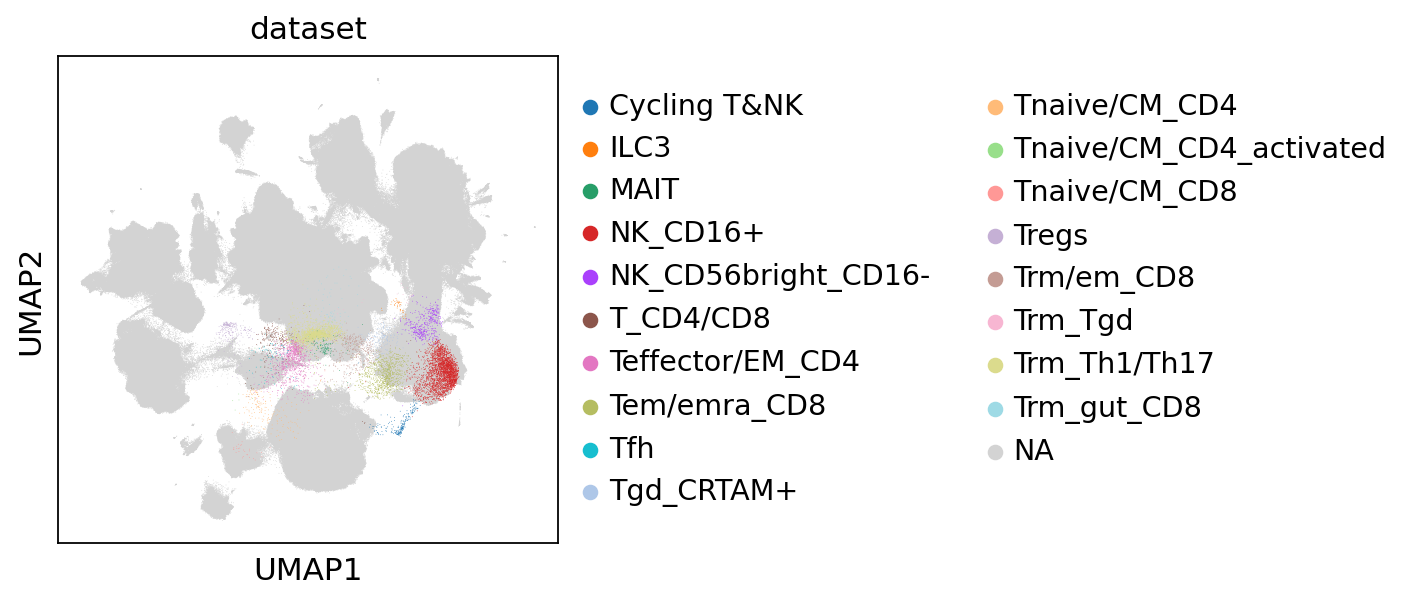

In [44]:
sc.pl.umap(
    combined_data,
    color=["Manually_curated_celltype"],
    ncols=1,
    frameon=True,
    save="combined_umap_celltype_panimmune.svg",
    size=combined_data.obs["umap_size"],
    title="dataset"
)

In [45]:
query = query_data.obsm['X_scanvi_emb']
query_nn_index = pynndescent.NNDescent(query)
query_nn_index.prepare()

## 5️⃣ Predict cell types

Let's predict using a different cell type than we did earlier, as that is too coarse grained (compartment-level resolution).

In [46]:
combined_neighbors, combined_distances = query_nn_index.query(combined_data.obsm['X_scanvi_emb'])

In [47]:
def distances_to_affinities(distances):
    # convert distances to affinities
    stds = np.std(distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)
    distances_tilda = np.exp(-np.true_divide(distances, stds))
    weights = distances_tilda / np.sum(
        distances_tilda, axis=1, keepdims=True
    )
    return weights

# import numba
# @numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

weights = distances_to_affinities(combined_distances)

### Predict

In [48]:
label_key = "Manually_curated_celltype"
query_cats = query_data.obs[label_key].cat.codes.to_numpy()[combined_neighbors]
p, u = weighted_prediction(weights, query_cats)
p = np.asarray(query_data.obs[label_key].cat.categories)[p]
combined_data.obs["celltype_pred"], combined_data.obs["celltype_uncertainty"] = p, u

/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


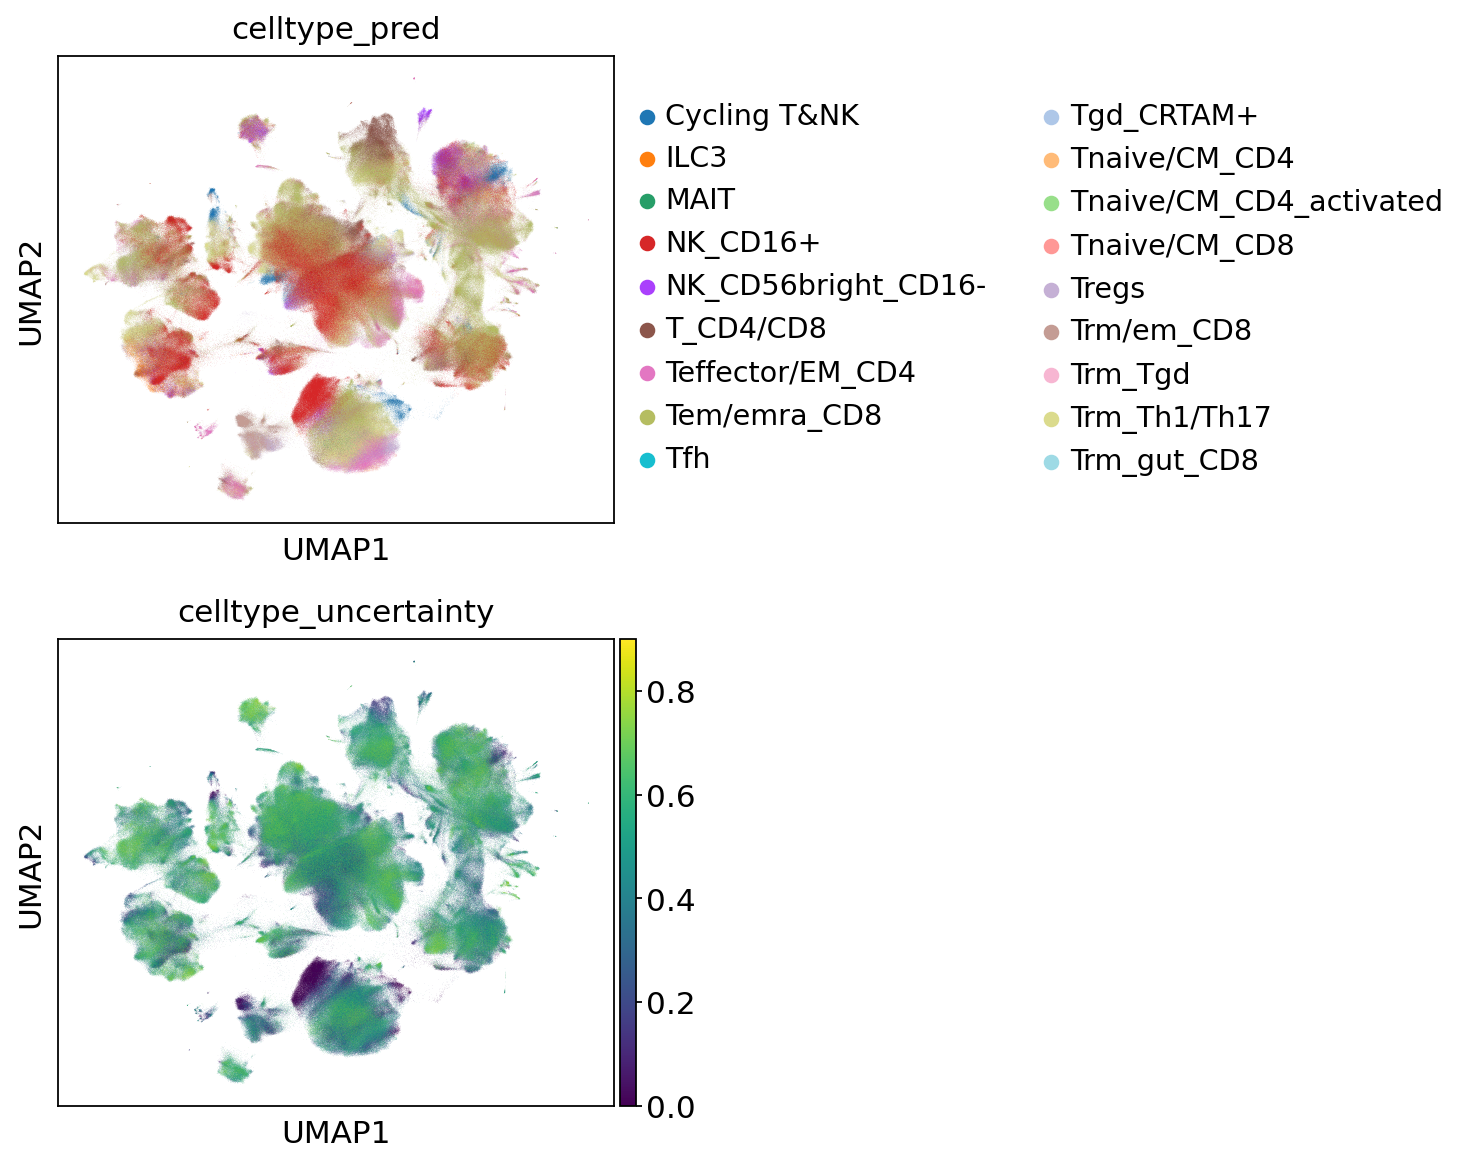

In [49]:
sc.pl.umap(
    combined_data,
    color=["celltype_pred", "celltype_uncertainty"],
    ncols=1,
    frameon=True,
    #save="combined_umap_celltype_panimmune.svg",
    #size=combined_data.obs["umap_size"],
    #title="dataset"
)

0.3846438432965748 0.5999371260404587


<Axes: ylabel='Density'>

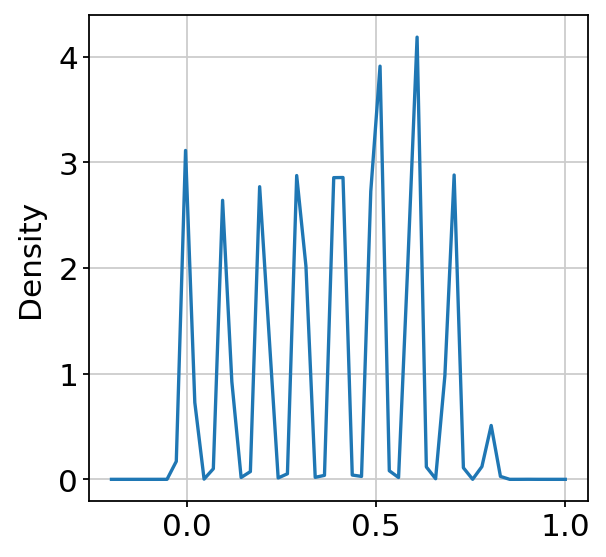

In [50]:
print(combined_data.obs["celltype_uncertainty"].mean(), np.quantile(combined_data.obs["celltype_uncertainty"], 0.75))
combined_data.obs["celltype_uncertainty"].plot(kind='density', ind=np.linspace(-0.2, 1))

In [51]:
query_combined = combined_data[combined_data.obs['batch'] == '1'].copy()

In [52]:
def get_comparison_df(uncertainty_threshold = None):
    # build comparison_df
    comparison_df = pd.DataFrame(index=query_combined.obs_names, columns=["pred", "ground_truth", "pred_uncertainty"])
    comparison_df["pred"] = query_combined.obs["celltype_pred"]
    comparison_df["pred_uncertainty"] = query_combined.obs["celltype_uncertainty"]
    comparison_df["ground_truth"] = query_combined.obs["Manually_curated_celltype"].fillna("Unknown")

    # we dont care about cases where we dont know the ground truth (in fact we could have skipped prediction for these altogether)
    n_before = len(comparison_df)
    comparison_df = comparison_df[comparison_df["ground_truth"] != "Unknown"]
    n_filtered = n_before-len(comparison_df)
    pct_filtered = 100*n_filtered/n_before
    print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with unknown ground truth")

    if uncertainty_threshold is not None:
        # filter out uncertainty > threshold
        n_before = len(comparison_df)
        comparison_df = comparison_df[comparison_df["pred_uncertainty"] <= uncertainty_threshold]
        n_filtered = n_before-len(comparison_df)
        pct_filtered = 100*n_filtered/n_before
        print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with pred uncertainty < {uncertainty_threshold}")

    return comparison_df

In [53]:
comparison_df = get_comparison_df(uncertainty_threshold=0.2)

filtered out 0 barcodes (0.00%) with unknown ground truth
filtered out 2559 barcodes (28.91%) with pred uncertainty < 0.2


In [54]:
query_data.obs['Manually_curated_celltype'].value_counts()

NK_CD16+                   2771
Trm_Th1/Th17               1876
Teffector/EM_CD4            947
Tem/emra_CD8                945
NK_CD56bright_CD16-         462
Trm/em_CD8                  417
Tregs                       256
T_CD4/CD8                   248
Cycling T&NK                216
Tnaive/CM_CD4               176
Tgd_CRTAM+                  148
MAIT                        124
Trm_gut_CD8                  82
Tfh                          79
ILC3                         40
Tnaive/CM_CD8                39
Trm_Tgd                      17
Tnaive/CM_CD4_activated       9
Name: Manually_curated_celltype, dtype: int64

In [55]:
comparison_df.groupby("pred")["pred_uncertainty"].mean()

pred
Cycling T&NK           0.035616
ILC3                        NaN
MAIT                   0.102293
NK_CD16+               0.014309
NK_CD56bright_CD16-    0.058239
T_CD4/CD8              0.122558
Teffector/EM_CD4       0.091383
Tem/emra_CD8           0.055312
Tfh                         NaN
Tgd_CRTAM+             0.126792
Tnaive/CM_CD4          0.141865
Tnaive/CM_CD8          0.165565
Tregs                  0.051332
Trm/em_CD8             0.107425
Trm_Tgd                     NaN
Trm_Th1/Th17           0.050943
Trm_gut_CD8                 NaN
Name: pred_uncertainty, dtype: float64

Some notes on the new HLCA annotations (https://zenodo.org/record/6337966/ vs https://zenodo.org/record/7599104):
- All new 60 cells have None for ann_level_3 annotations.
- No cells was predicted as "Smooth muscle FAM83D+" (even before thresholding on prediction uncertainty)
- In prev ann_level_3, not in new: 'Fibromyocytes'
- In new ann_level_3, not in prev: 'Smooth muscle FAM83D+'
- Only 565 cells differ between prev and new ann_level_3 annotations and their distribution is (prev, new):  
Fibromyocytes,Smooth muscle FAM83D+   -> 335  
Secretory,AT2                       ->   230

In [56]:
# https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cellassign_tutorial.html#Model-reproducibility
confusion_matrix = pd.crosstab(
    comparison_df["pred"],
    comparison_df["ground_truth"], 
    rownames=["Predicted label"],
    colnames=["True label"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
confusion_matrix *= 100

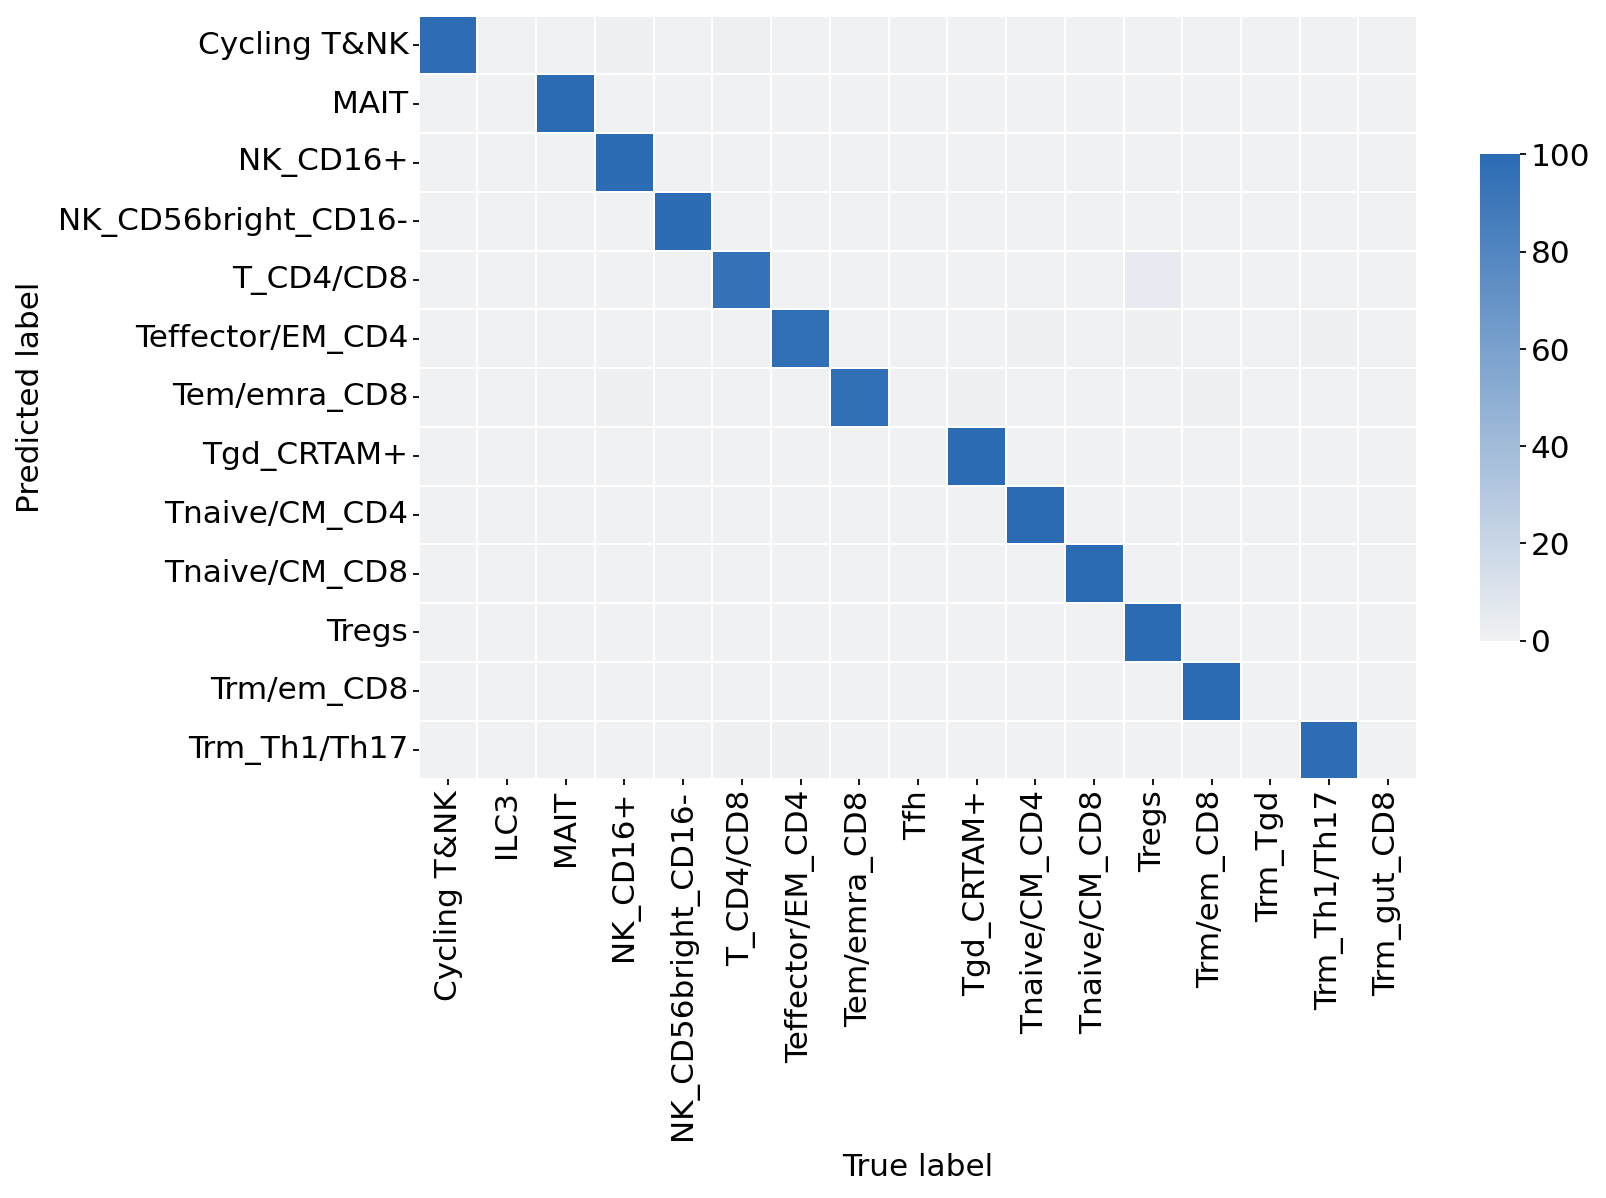

In [57]:
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    confusion_matrix,
    # cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    ax=ax,
    square=True,
    fmt=".2f",
    cbar_kws=dict(shrink=0.4, aspect=12),
    #linecolor='white',
    linewidths=0.2, 
    # annot=True,
    # norm=LogNorm()
)
plt.grid(False)
plt.savefig('confusion_matrix_query_to_ref.png', dpi=300)
plt.show()

In [58]:
combined_data.obs['ann_level_3'].value_counts()

Macrophages                     524452
Unknown                         280408
T cell lineage                  245605
Secretory                       181002
AT2                             157476
Basal                           144420
Fibroblasts                     129222
Multiciliated lineage           124124
Monocytes                       107416
B cell lineage                   71270
EC capillary                     70759
Innate lymphoid cell NK          48439
Dendritic cells                  41291
EC venous                        37838
AT1                              32306
Mast cells                       21323
EC arterial                      14724
Lymphatic EC mature              11680
Submucosal Secretory             11001
None                              3286
Rare                              3039
Myofibroblasts                    1926
SM activated stress response      1788
Lymphatic EC differentiating      1359
Smooth muscle FAM83D+              553
Lymphatic EC proliferatin

In [59]:
ref_tcell = combined_data[np.logical_or(combined_data.obs['ann_level_3'].isin(['T cell lineage', 'Innate lymphoid cell NK']), combined_data.obs['batch']=='1')]

/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/umap/d

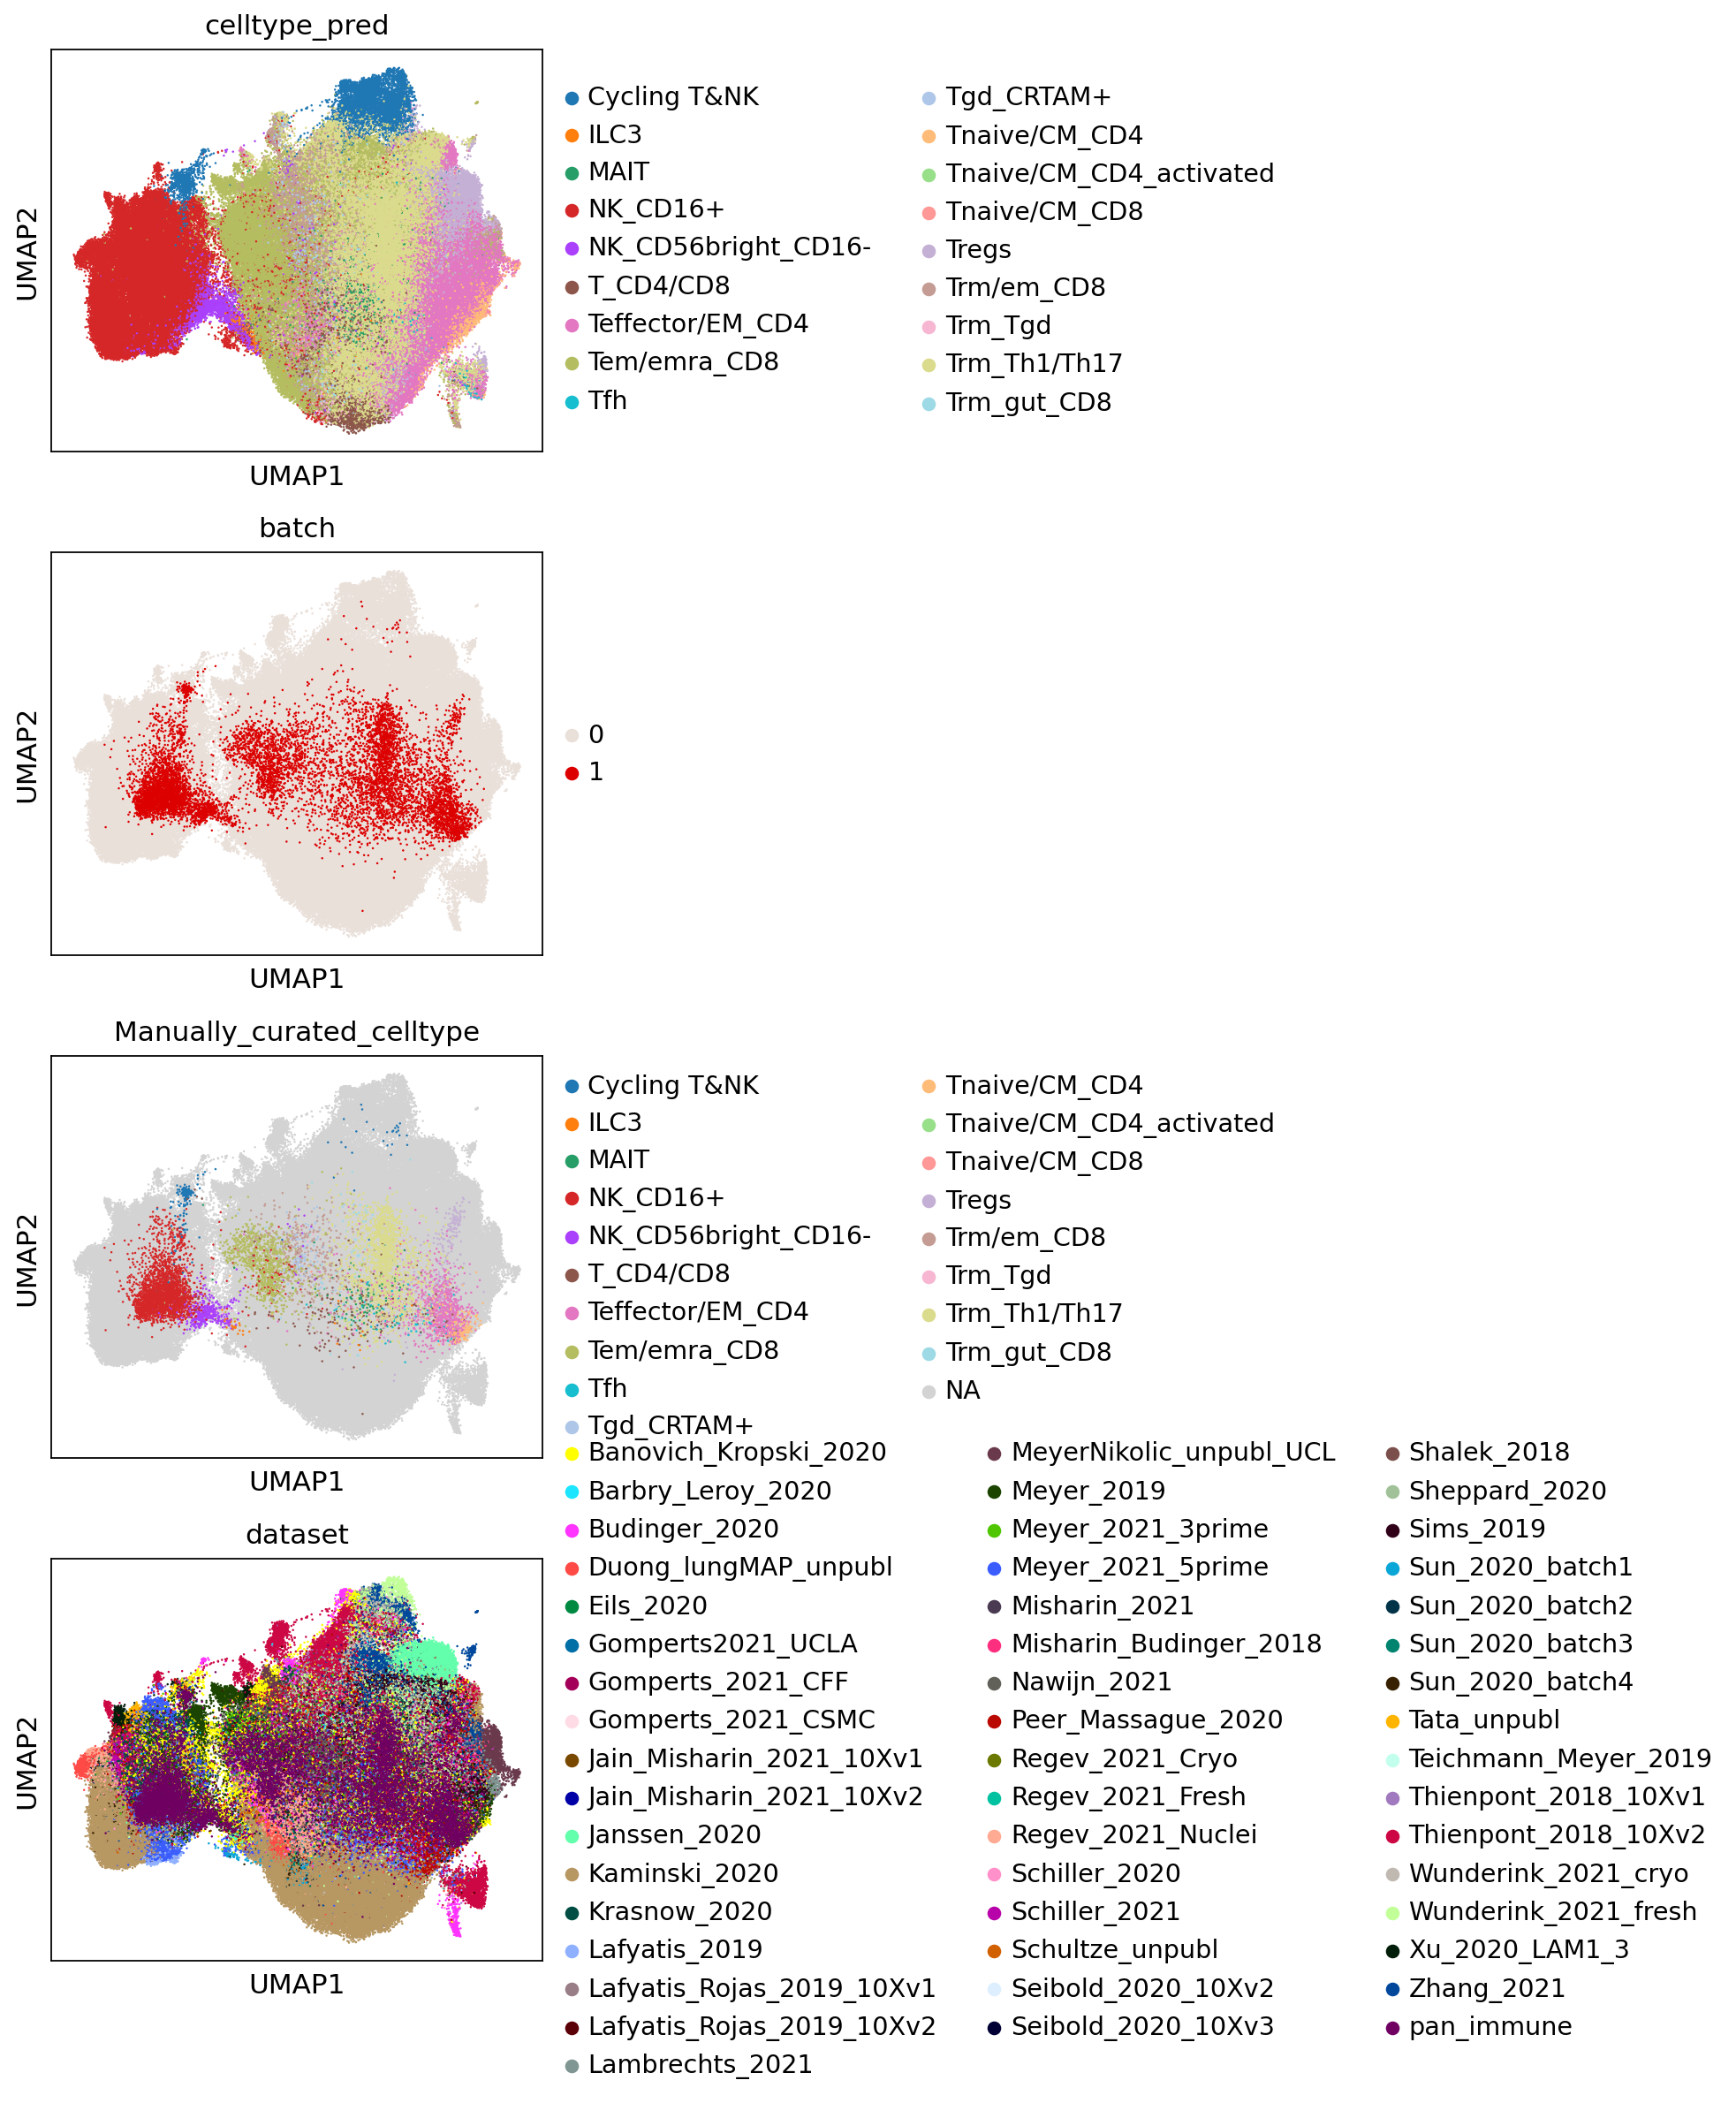

In [64]:
sc.pp.neighbors(ref_tcell, use_rep="X_scanvi_emb")
sc.tl.umap(ref_tcell)
sc.pl.umap(ref_tcell, color=['celltype_pred', 'batch', 'Manually_curated_celltype', 'dataset'], ncols=1, size=5)#, save='_predicted_tcells.svg')

In [65]:
ref_tcell2 = ref_tcell.copy()
ref_tcell.var.index = ref_tcell.var['feature_name-0']

In [66]:
set(['PDCD1', 'CXCR5', 'IL21', 'BCL6', 'CD8A', 'GZMA', 'GZMB', 'GZMK', 'CCR7', 'KLRB1', 'KLRG1', 'MKI67', 'TYROBP']).intersection(ref_tcell.var.index)

{'CCR7',
 'CD8A',
 'CXCR5',
 'GZMA',
 'GZMB',
 'GZMK',
 'IL21',
 'KLRB1',
 'KLRG1',
 'MKI67',
 'PDCD1',
 'TYROBP'}

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


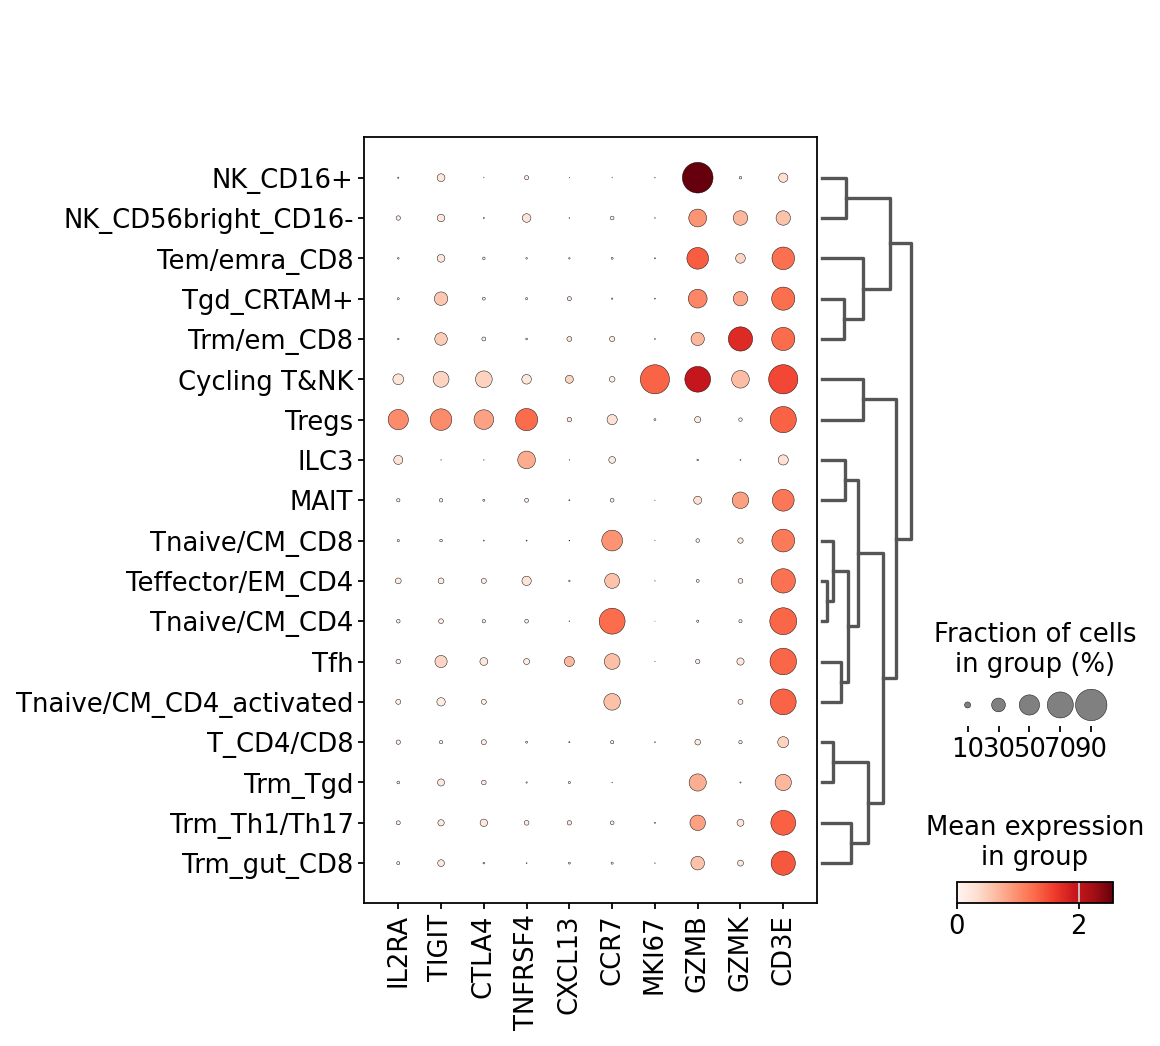

In [67]:
sc.pl.dotplot(ref_tcell, var_names=['IL2RA', 'TIGIT', 'CTLA4', 'TNFRSF4', 'CXCL13', 'CCR7', 'MKI67', 'GZMB', 'GZMK', 'CD3E'],
              groupby='celltype_pred', gene_symbols='feature_name-0', save='_predicted_treg_markers.svg', use_raw=False, dendrogram=True)

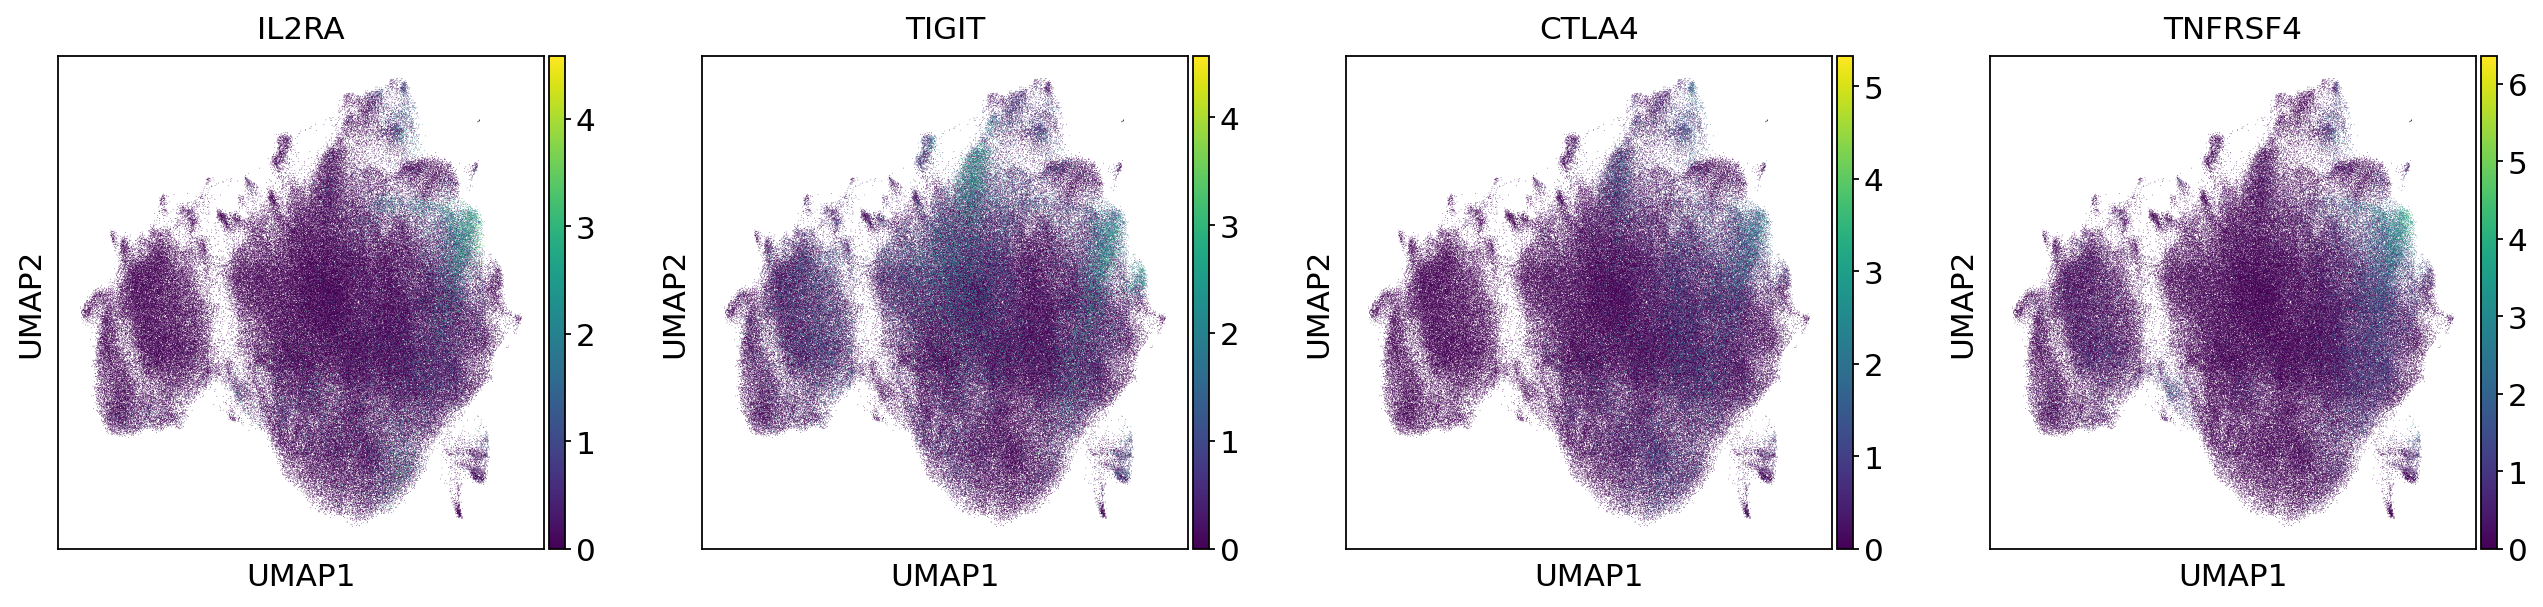

In [68]:
sc.pl.umap(ref_tcell, color=['IL2RA', 'TIGIT', 'CTLA4', 'TNFRSF4'], gene_symbols='feature_name-0', save='_predicted_treg_markers.svg')

In [69]:
ref_tregs = combined_data[np.logical_and(combined_data.obs['ann_level_3'].isin(['T cell lineage', 'Innate lymphoid cell NK']), combined_data.obs['celltype_pred']=='Tem/emra_CD8')]

In [70]:
combined_data.obs['celltype_pred'].value_counts()

NK_CD16+                   610641
Tem/emra_CD8               560807
Trm_Th1/Th17               450411
T_CD4/CD8                  184172
Teffector/EM_CD4           176753
NK_CD56bright_CD16-         79294
Trm/em_CD8                  67169
Tregs                       41970
Cycling T&NK                41245
ILC3                        37203
Tgd_CRTAM+                  15731
MAIT                        12876
Tnaive/CM_CD4                5044
Tfh                          2974
Trm_gut_CD8                  2247
Tnaive/CM_CD8                1038
Trm_Tgd                       968
Tnaive/CM_CD4_activated       756
Name: celltype_pred, dtype: int64

In [71]:
adata_url = "https://cellxgene.cziscience.com/e/066943a2-fdac-4b29-b348-40cede398e4e.cxg/"
b = cellxgene(adata_url, filename="adata_extended2.h5ad", save_path=local_dir)

In [72]:
raw_tregs = b[[i[:-2] for i in ref_tregs.obs_names]].copy()
raw_tregs.X = raw_tregs.raw.X

In [73]:
raw_tregs.var_names = raw_tregs.var['feature_name'].astype(str)

In [74]:
raw_tregs.obs['batch'] = raw_tregs.obs['donor_id'].astype(str) + raw_tregs.obs['dataset'].astype(str) + raw_tregs.obs['assay'].astype(str) + raw_tregs.obs['disease'].astype(str)

In [75]:
import decoupler as dc

# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    raw_tregs,
    sample_col='batch',
    groups_col=None,
    mode='sum',
    min_cells=10,
    min_counts=1000,
)
pdata

AnnData object with n_obs × n_vars = 307 × 37023
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'ann_level_1', 'ann_level_2', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'mixed_ancestry', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_dissociation_protocol', 'transf_ann_level_1_label', 'transf_ann_level_2_label', 'assay', 'disease', 'organism', 'sex', 'self_reported_ethnicity', 'development_stage', 'batch', 'psbulk_n_cells', 'psbulk_counts'
    var: 'feature_is_filtered', 'original_gene_symbols', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props'

In [76]:
pdata

AnnData object with n_obs × n_vars = 307 × 37023
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'ann_level_1', 'ann_level_2', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'mixed_ancestry', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_dissociation_protocol', 'transf_ann_level_1_label', 'transf_ann_level_2_label', 'assay', 'disease', 'organism', 'sex', 'self_reported_ethnicity', 'development_stage', 'batch', 'psbulk_n_cells', 'psbulk_counts'
    var: 'feature_is_filtered', 'original_gene_symbols', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props'

/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


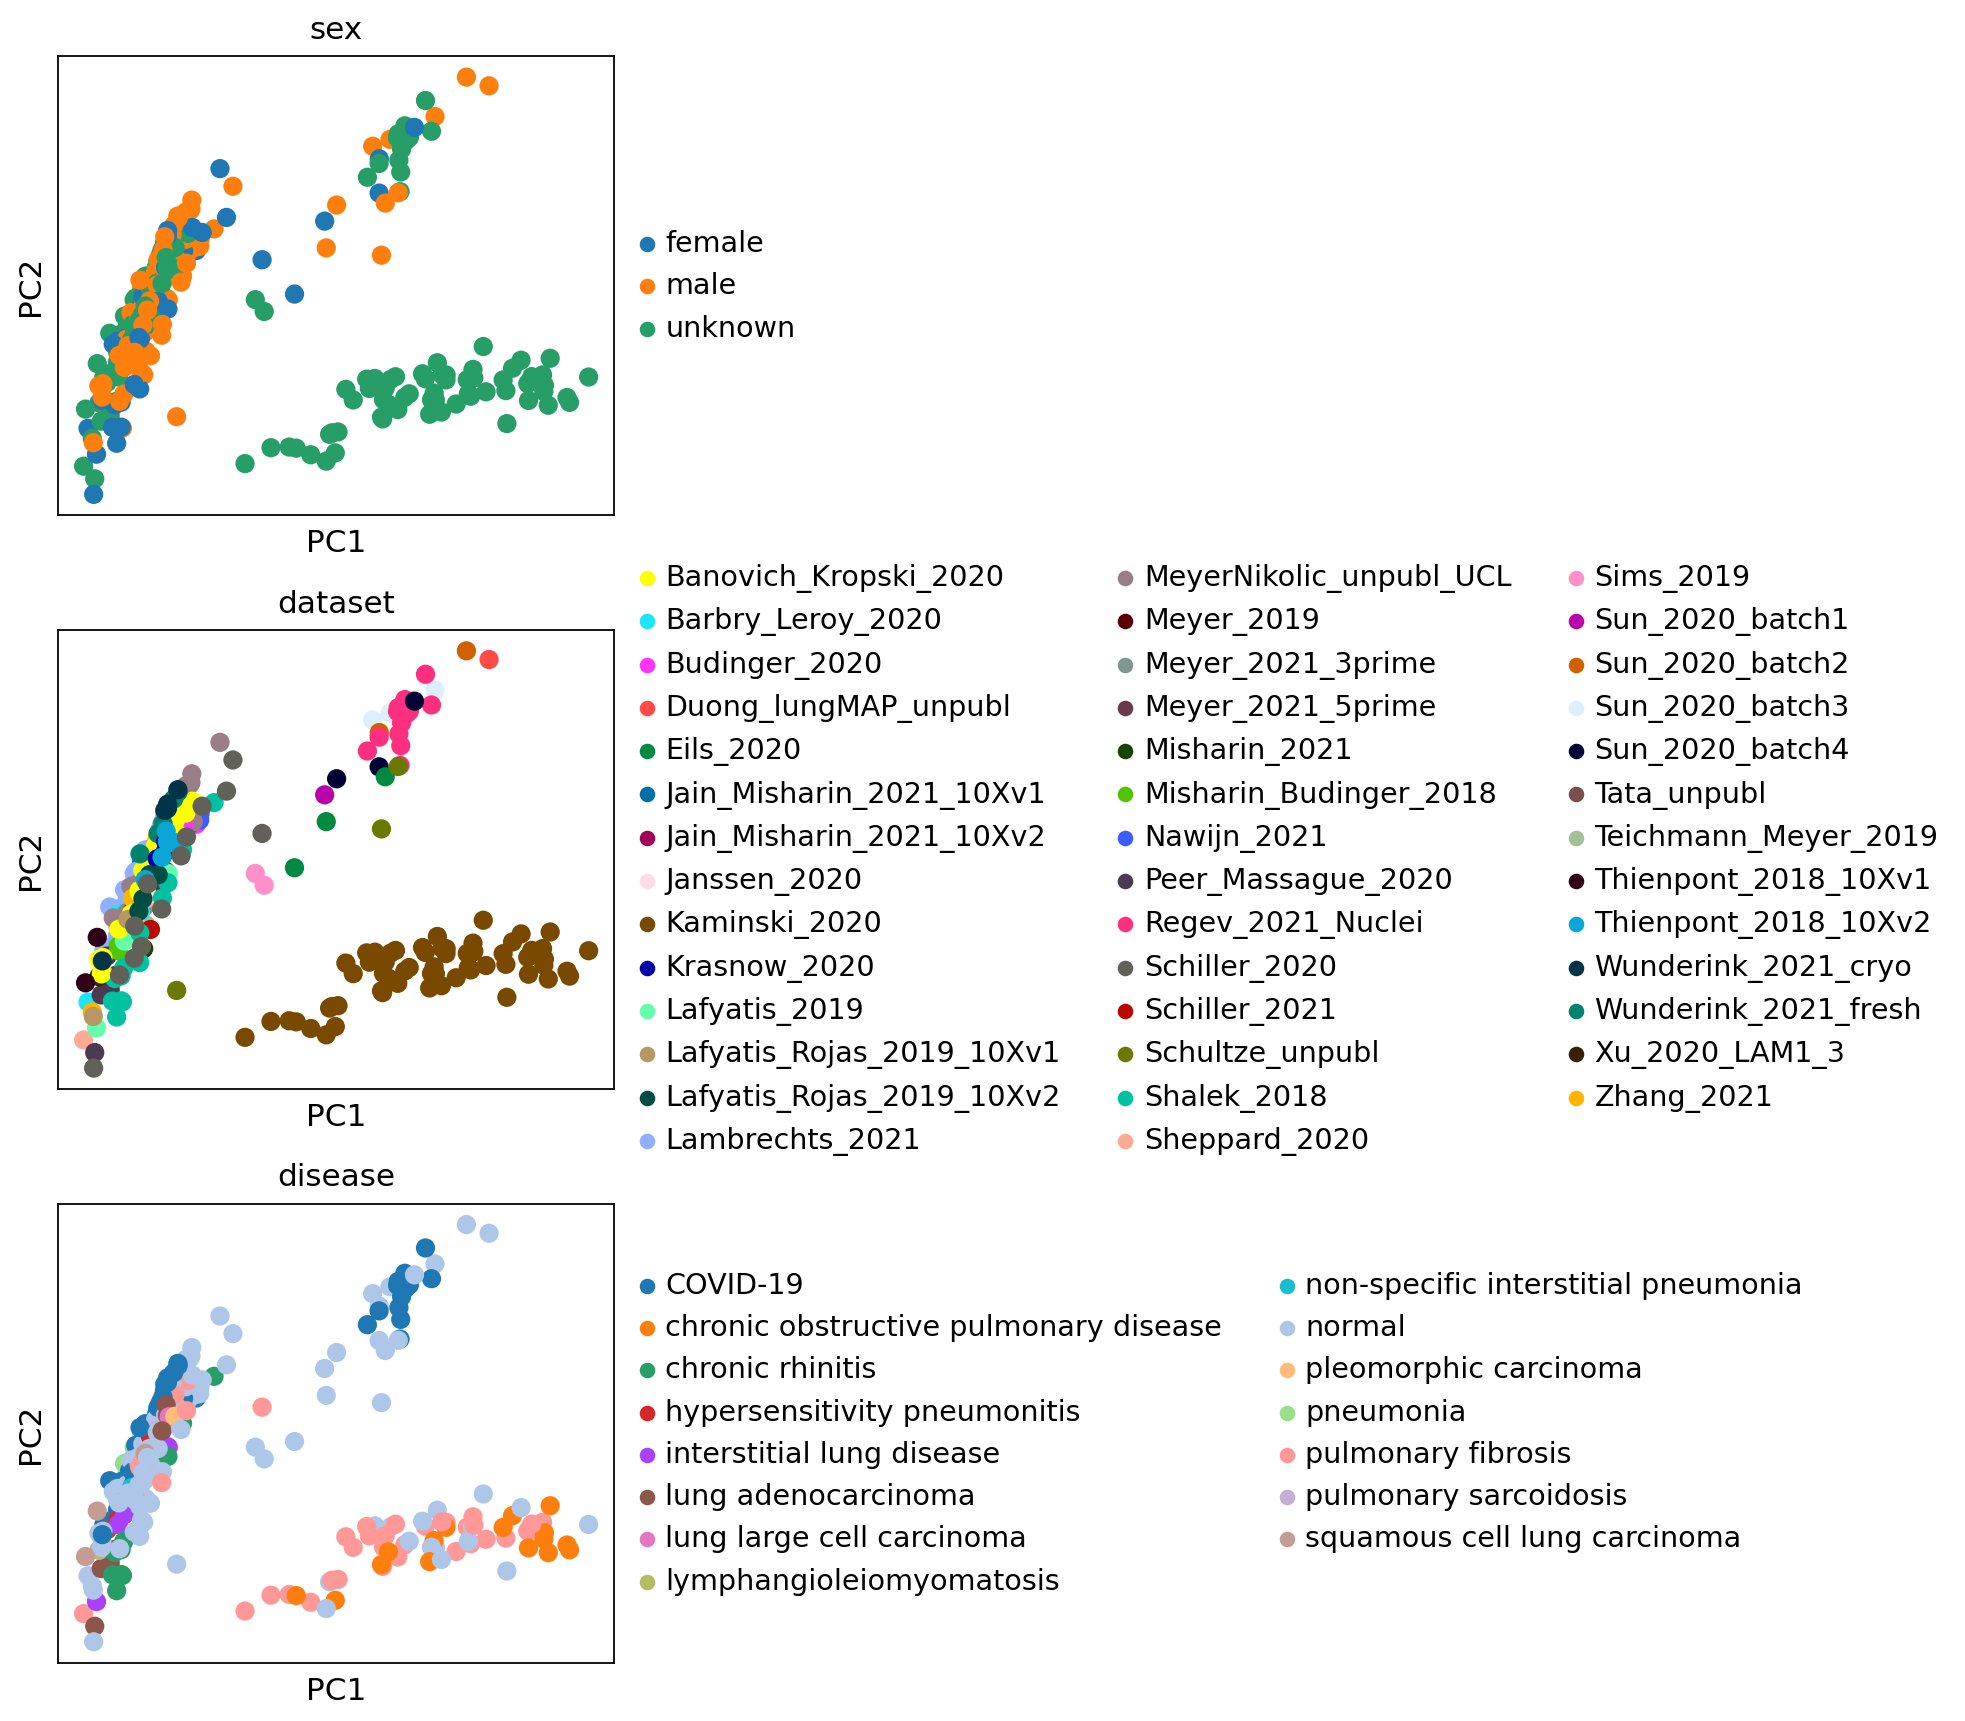

In [77]:
pp_pdata = pdata.copy()
sc.pp.normalize_total(pp_pdata, target_sum=1e6)
sc.pp.log1p(pp_pdata)
sc.pp.scale(pp_pdata, max_value=10)
sc.tl.pca(pp_pdata, n_comps=10)
sc.pl.pca(pp_pdata, color=['sex', 'dataset', 'disease'], ncols=1, show=True, size=300)

In [78]:
pdata.obs['disease'].value_counts()

normal                                   155
COVID-19                                  50
pulmonary fibrosis                        44
chronic obstructive pulmonary disease     16
lung adenocarcinoma                       11
chronic rhinitis                          10
pneumonia                                  5
interstitial lung disease                  5
squamous cell lung carcinoma               3
hypersensitivity pneumonitis               2
lymphangioleiomyomatosis                   2
pulmonary sarcoidosis                      1
non-specific interstitial pneumonia        1
lung large cell carcinoma                  1
pleomorphic carcinoma                      1
Name: disease, dtype: int64

In [79]:
# Obtain genes that pass the thresholds

genes = dc.filter_by_expr(pdata, group='sex', min_count=2, min_total_count=15)

# Filter by these genes
pdatas = pdata[:, genes].copy()
pdatas, pdatas[:, 'XIST']

disease = 'COVID-19' #'pulmonary fibrosis'
pdatas = pdatas[pdata.obs['disease'].isin([disease, 'normal'])].copy()

In [80]:
pdatas

AnnData object with n_obs × n_vars = 205 × 10017
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'ann_level_1', 'ann_level_2', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'mixed_ancestry', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_dissociation_protocol', 'transf_ann_level_1_label', 'transf_ann_level_2_label', 'assay', 'disease', 'organism', 'sex', 'self_reported_ethnicity', 'development_stage', 'batch', 'psbulk_n_cells', 'psbulk_counts'
    var: 'feature_is_filtered', 'original_gene_symbols', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props'

In [81]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [ ]:
import decoupler as dc

# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    raw_tregs,
    sample_col='batch',
    groups_col=None,
    mode='sum',
    min_cells=10,
    min_counts=1000,
)
pdata

# Obtain genes that pass the thresholds

genes = dc.filter_by_expr(pdata, group='sex', min_count=2, min_total_count=15)

# Filter by these genes
pdatas = pdata[:, genes].copy()

disease = 'COVID-19' #'pulmonary fibrosis'
pdatas = pdatas[pdata.obs['disease'].isin([disease, 'normal'])].copy()

# Build DESeq2 object
dds = DeseqDataSet(
    adata=pdatas,
    design_factors=['disease', 'sex', 'assay'], #, 'dataset', 
    refit_cooks=True,
    n_cpus=8,
)

# Compute LFCs
dds.deseq2()
stat_res = DeseqStats(dds, contrast=["disease", disease, 'normal'], n_cpus=8)

In [90]:
# Compute Wald test
stat_res.summary()
# Extract results
results_df = stat_res.results_df
results_df

Log2 fold change & Wald test p-value: disease COVID-19 vs normal


baseMean  log2FoldChange     lfcSE      stat        pvalue  \
feature_name                                                                
A1BG           4.974161       -0.606035  0.227543 -2.663385  7.735885e-03   
A2M            8.348769       -3.156780  0.603816 -5.228047  1.713096e-07   
A2M-AS1        2.248167        0.380905  0.457562  0.832466  4.051459e-01   
A2MP1          1.340328       -2.655935  1.376025 -1.930150  5.358821e-02   
AAAS           2.371162       -0.465844  0.158076 -2.946967  3.209077e-03   
...                 ...             ...       ...       ...           ...   
ZWILCH         1.480450        0.367165  0.246179  1.491454  1.358424e-01   
ZXDC           4.383156       -0.124916  0.330758 -0.377667  7.056783e-01   
ZYG11B         2.267805       -0.489981  0.303030 -1.616942  1.058909e-01   
ZZEF1         10.019056       -0.007297  0.234157 -0.031161  9.751412e-01   
ZZZ3           8.850186       -0.058235  0.316239 -0.184147  8.538978e-01   

                  padj  
feature_name            
A1BG          0.040084  
A2M           0.000008  
A2M-AS1       0.584549  
A2MP1         0.154147  
AAAS          0.020994  
...                ...  
ZWILCH        0.284823  
ZXDC          0.827643  
ZYG11B        0.242666  
ZZEF1         0.985572  
ZZZ3          0.922515  

[10017 rows x 6 columns]

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
feature_name                                                                
A1BG           4.974161       -0.606035  0.227543 -2.663385  7.735885e-03   
A2M            8.348769       -3.156780  0.603816 -5.228047  1.713096e-07   
A2M-AS1        2.248167        0.380905  0.457562  0.832466  4.051459e-01   
A2MP1          1.340328       -2.655935  1.376025 -1.930150  5.358821e-02   
AAAS           2.371162       -0.465844  0.158076 -2.946967  3.209077e-03   
...                 ...             ...       ...       ...           ...   
ZWILCH         1.480450        0.367165  0.246179  1.491454  1.358424e-01   
ZXDC           4.383156       -0.124916  0.330758 -0.377667  7.056783e-01   
ZYG11B         2.267805       -0.489981  0.303030 -1.616942  1.058909e-01   
ZZEF1         10.019056       -0.007297  0.234157 -0.031161  9.751412e-01   
ZZZ3           8.850186       -0.058235  0.316239 -0.184147  8.538978e-01   

                  padj  
feature_name            
A1BG          0.040084  
A2M           0.000008  
A2M-AS1       0.584549  
A2MP1         0.154147  
AAAS          0.020994  
...                ...  
ZWILCH        0.284823  
ZXDC          0.827643  
ZYG11B        0.242666  
ZZEF1         0.985572  
ZZZ3          0.922515  

[10017 rows x 6 columns]

In [91]:
import adjustText as at

def filter_limits(df, sign_limit=None, lFCs_limit=None):

    # Define limits if not defined
    if sign_limit is None:
        sign_limit = np.inf
    if lFCs_limit is None:
        lFCs_limit = np.inf

    # Filter by absolute value limits
    if sign_limit is not None:
        df.loc[df['pvals'] > sign_limit, 'pvals'] = 0.99 * sign_limit
    if lFCs_limit is not None:
        df.loc[np.abs(df['logFCs']) > lFCs_limit, 'logFCs'] = 0.99 * np.sign(df.loc[np.abs(df['logFCs']) > lFCs_limit, 'logFCs']) * lFCs_limit

    return df

def plot_volcano_selected(data, x, y, genes, sign_thr=0.05, lFCs_thr=0.5, sign_limit=3, lFCs_limit=3,
                    figsize=(7, 5), dpi=100, ax=None, return_fig=False, save=None):
    """
    Plot logFC and p-values from a long formated data-frame.
    Parameters
    ----------
    data : pd.DataFrame
        Results of DEA in long format.
    x : str
        Column name of data storing the logFCs.
    y : str
        Columns name of data storing the p-values.
    top : int
    """
    # Transform sign_thr
    sign_thr = -np.log10(sign_thr)

    # Extract df
    df = data.copy()
    df['logFCs'] = df[x]
    df['pvals'] = -np.log10(df[y])

    # Filter by limits
    df = filter_limits(df, sign_limit=sign_limit, lFCs_limit=lFCs_limit)
    
    df['weight'] = 'gray'
    up_msk = (df['logFCs'] >= lFCs_thr) & (df['pvals'] >= sign_thr)
    dw_msk = (df['logFCs'] <= -lFCs_thr) & (df['pvals'] >= sign_thr)
    df.loc[up_msk, 'weight'] = '#D62728'
    df.loc[dw_msk, 'weight'] = '#1F77B4'

    # Plot
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    df.plot.scatter(x='logFCs', y='pvals', c='weight', sharex=False, ax=ax, s=15, alpha=0.6, xlim=(-lFCs_limit, lFCs_limit), ylim=(-0.2, sign_limit))

    # Draw sign lines
    ax.axhline(y=sign_thr, linestyle='--', color="black")
    ax.axvline(x=lFCs_thr, linestyle='--', color="black")
    ax.axvline(x=-lFCs_thr, linestyle='--', color="black")

    # Plot top sign features
    signs = df.reindex(genes).dropna()

    # Add labels
    ax.set_ylabel('-log10(pvals)')
    texts = []
    for x, y, s in zip(signs['logFCs'], signs['pvals'], signs.index):
        texts.append(ax.text(x, y, s, size=12))
    if len(texts) > 0:
        at.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), ax=ax)
        
    if return_fig:
        return 

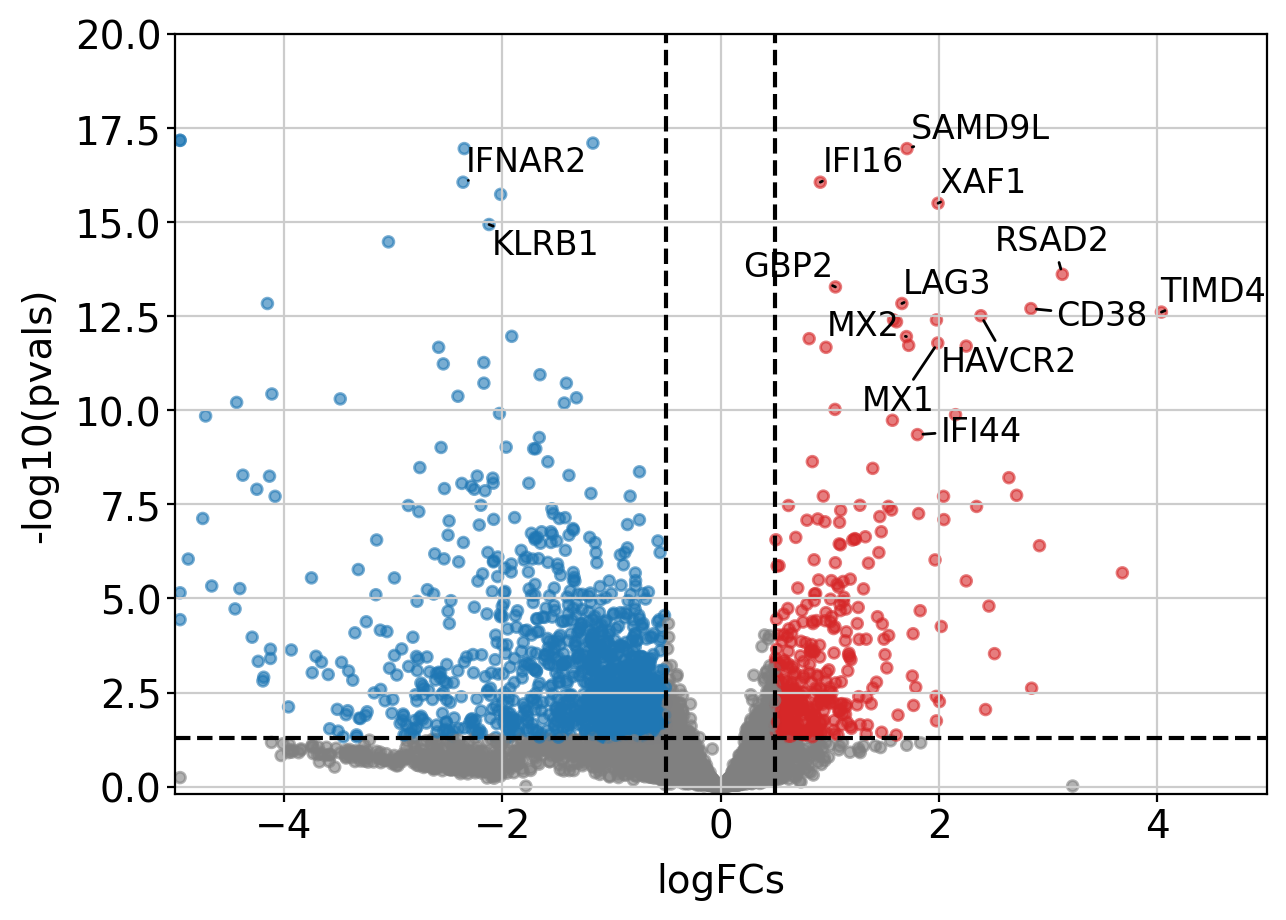

In [97]:
results_df = stat_res.results_df
plot_volcano_selected(results_df, x='log2FoldChange', y='padj',
                      genes=['IFI16', 'LAG3', 'CD38', 'TIMD4', 'MX1', 'MX2', 'GBP2', 'HAVCR2', 'IFI44', 'IFNAR2', 'KLRB1', 'SAMD9L', 'XAF1', 'RSAD2'],
                      sign_limit=20, lFCs_limit=5)
plt.savefig('cd8_trm_covid_pseudobulk_sex.svg')
plt.show()

# Benchmark using wrong model

In [ ]:
from scvi.data import cellxgene

local_dir = "/home/cane/Documents/yoseflab/can/scvi-hub"
adata_url = "https://cellxgene.cziscience.com/e/97a17473-e2b1-4f31-a544-44a60773e2dd.cxg/"
query_data = cellxgene(adata_url, filename="ts_epithelial.h5ad", save_path=local_dir)

In [ ]:
query_data.X = query_data.raw[:, query_data.var_names].X.toarray()

In [ ]:
import scvi
from scvi.criticism import PosteriorPredictiveCheck as PPC

In [ ]:
# add dataset information:
query_data.obs['dataset'] = query_data.obs['tissue']

In [ ]:
scvi.model.SCANVI.prepare_query_anndata(query_data, local_dir)
query_data.obs["scanvi_label"] = "unlabeled"

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               
INFO     Found 100.0% reference vars in query data.                                                                


## Build a query model

Use `prepare_query_anndata` to re-order the genes and pad any missing genes with 0s, so that query_adata matches exactly the reference in terms of its gene set.  

In [ ]:
query_model = scvi.model.SCANVI.load_query_data(query_data, local_dir, accelerator = "cpu")

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               


/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
query_model.adata

AnnData object with n_obs × n_vars = 104148 × 2000
    obs: 'tissue_in_publication', 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    obsp: 'connectivities', 'distances'

Train the query model.

In [ ]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [ ]:
query_model.train(
    max_epochs=surgery_epochs,
    accelerator="gpu",
    **train_kwargs_surgery,
)

INFO     Training for 500 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 301/500:  60%|██████    | 301/500 [20:11<13:21,  4.03s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.31e+3]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 1332.213. Signaling Trainer to stop.


In [ ]:
query_save_path = f"{local_dir}/query_model_ts_epithelial"
query_model.save(query_save_path, overwrite=True)

In [ ]:
query_save_path = f"{local_dir}/query_model_ts_epithelial"
query_model = scvi.model.SCANVI.load(query_save_path, adata=query_data)

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/query_model_ts_epithelial/model.pt already downloaded     


In [ ]:
query_data.obsm['X_scanvi_emb'] = query_model.get_latent_representation()

In [ ]:
import scvi.criticism as criticism
from ppc_plot_utils import PPCPlot

In [ ]:
temp_fig_dir = "/home/cane/Documents/yoseflab/can/scvi-hub/scvi-hub-reproducibility/figures_query/"

In [ ]:
# marginal_ll = []
# for i in range(query_data.n_obs):
#    marginal_ll.append(query_model.get_marginal_ll(indices=[i]))

In [ ]:
query_model.adata.obs['tissue'].unique()

['liver', 'trachea', 'parotid gland', 'anterior part of tongue', 'posterior part of tongue', ..., 'lung', 'small intestine', 'kidney', 'endocrine pancreas', 'aorta']
Length: 32
Categories (32, object): ['endocrine pancreas', 'exocrine pancreas', 'large intestine', 'aorta', ..., 'retinal neural layer', 'anterior part of tongue', 'posterior part of tongue', 'bladder organ']

In [ ]:
import copy

ScanVI Model with the following params: 
unlabeled_category: unlabeled, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: False

In [ ]:
ppc = {}
for tissue in query_model.adata.obs['tissue'].unique():
    print(tissue)
    q_model = copy.deepcopy(query_model)
    q_model.adata = q_model.adata[q_model.adata.obs['tissue']==tissue].copy()
    ppc[tissue] = PPC(q_model.adata, {"SCANVI": q_model}, n_samples=10)
    ppc[tissue] = criticism.PosteriorPredictiveCheck(q_model.adata, {"SCANVI": q_model})
    # expected runtime ~8min
    ppc[tissue].coefficient_of_variation("features")

    ppc_plt = PPCPlot(ppc[tissue])
    ppc_plt.plot_cv(model_name="SCANVI", cell_wise=True, plt_type="hist2d")

    fig_path = f'{temp_fig_dir}/ppc_cv_cell_ts_query_{tissue}.svg'
    plt.savefig(fig_path, dpi=600, bbox_inches="tight")
    plt.title(tissue)
    plt.show()

model=SCANVI | metric=cv_cell | n_cells=1600:
Mean Absolute Error=1.78,
Pearson correlation=0.78
Spearman correlation=0.77
r^2=0.38



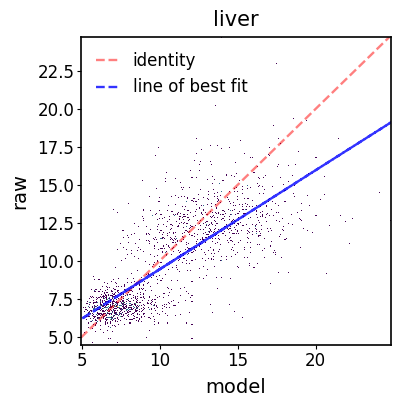

model=SCANVI | metric=cv_cell | n_cells=5047:
Mean Absolute Error=1.26,
Pearson correlation=0.78
Spearman correlation=0.80
r^2=0.61



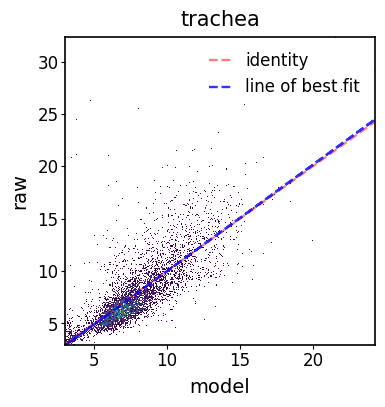

model=SCANVI | metric=cv_cell | n_cells=8932:
Mean Absolute Error=2.89,
Pearson correlation=0.30
Spearman correlation=0.14
r^2=-0.49



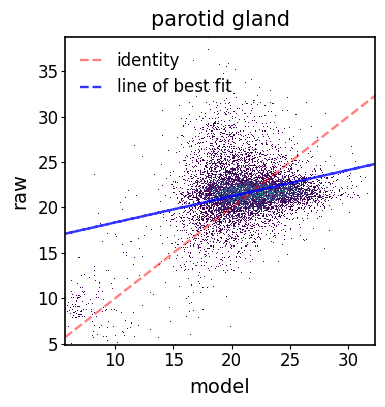

model=SCANVI | metric=cv_cell | n_cells=4498:
Mean Absolute Error=2.86,
Pearson correlation=0.18
Spearman correlation=0.15
r^2=-0.86



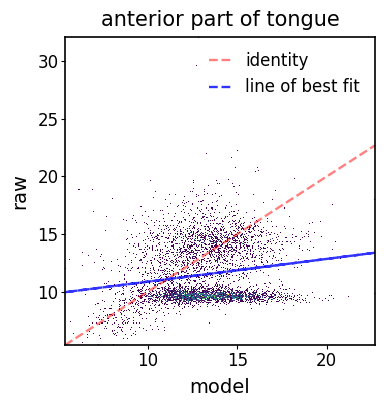

model=SCANVI | metric=cv_cell | n_cells=7395:
Mean Absolute Error=1.84,
Pearson correlation=0.71
Spearman correlation=0.74
r^2=0.36



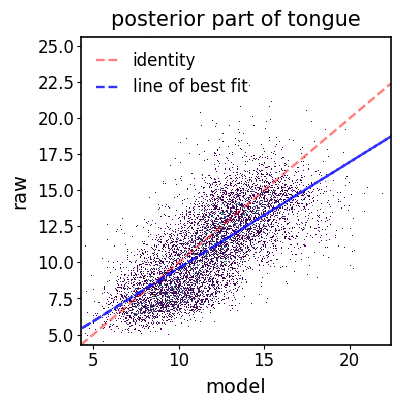

model=SCANVI | metric=cv_cell | n_cells=5854:
Mean Absolute Error=3.13,
Pearson correlation=0.40
Spearman correlation=0.47
r^2=-0.50



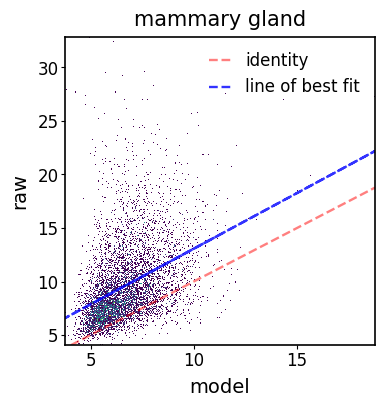

model=SCANVI | metric=cv_cell | n_cells=230:
Mean Absolute Error=1.09,
Pearson correlation=0.25
Spearman correlation=0.37
r^2=-0.50



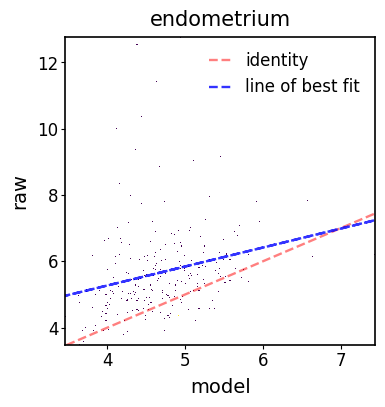

model=SCANVI | metric=cv_cell | n_cells=9:
Mean Absolute Error=2.05,
Pearson correlation=-0.36
Spearman correlation=-0.40
r^2=-0.53



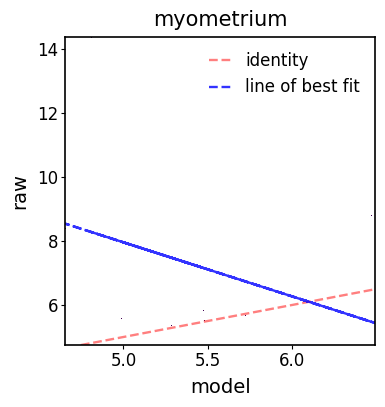

model=SCANVI | metric=cv_cell | n_cells=2052:
Mean Absolute Error=2.32,
Pearson correlation=0.22
Spearman correlation=0.16
r^2=-0.89



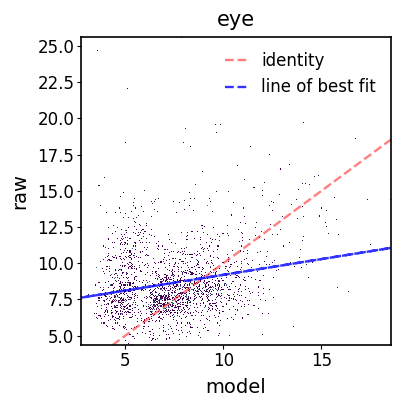

model=SCANVI | metric=cv_cell | n_cells=2084:
Mean Absolute Error=0.61,
Pearson correlation=0.33
Spearman correlation=0.35
r^2=-0.10



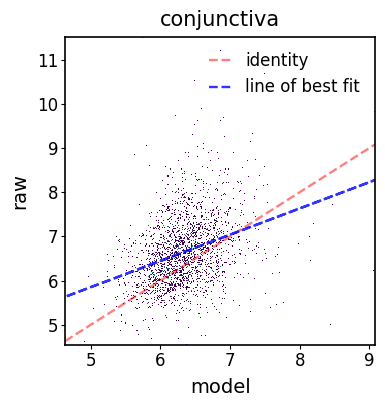

model=SCANVI | metric=cv_cell | n_cells=59:
Mean Absolute Error=4.72,
Pearson correlation=0.03
Spearman correlation=0.09
r^2=-1.32



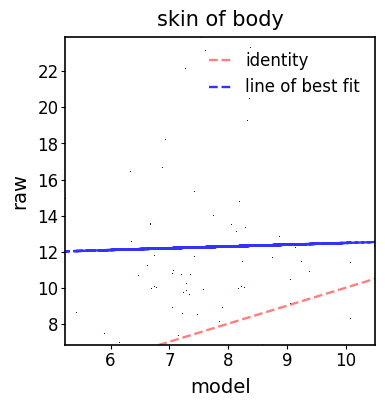

model=SCANVI | metric=cv_cell | n_cells=787:
Mean Absolute Error=3.65,
Pearson correlation=0.23
Spearman correlation=0.19
r^2=-0.94



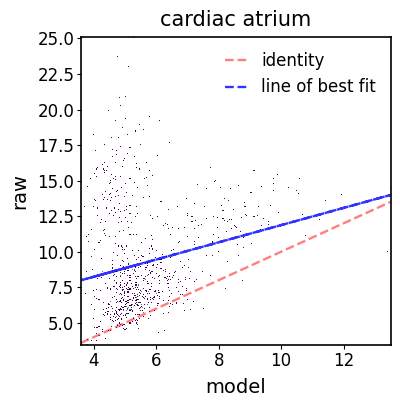

model=SCANVI | metric=cv_cell | n_cells=302:
Mean Absolute Error=3.81,
Pearson correlation=-0.03
Spearman correlation=-0.01
r^2=-1.20



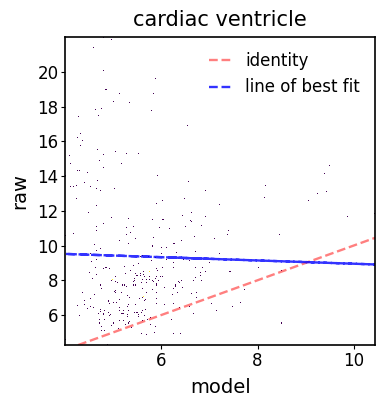

model=SCANVI | metric=cv_cell | n_cells=7128:
Mean Absolute Error=7.62,
Pearson correlation=0.61
Spearman correlation=0.67
r^2=-0.75



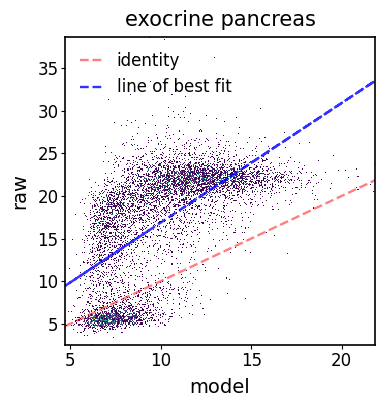

model=SCANVI | metric=cv_cell | n_cells=12316:
Mean Absolute Error=3.56,
Pearson correlation=0.39
Spearman correlation=0.40
r^2=-0.45



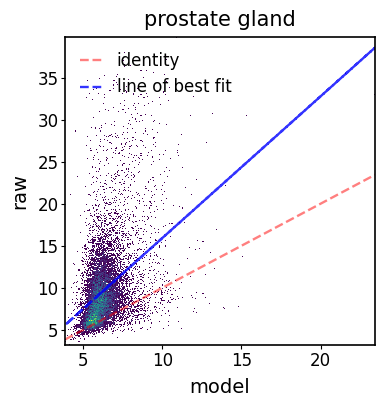

model=SCANVI | metric=cv_cell | n_cells=9:
Mean Absolute Error=3.80,
Pearson correlation=0.35
Spearman correlation=0.08
r^2=-2.78



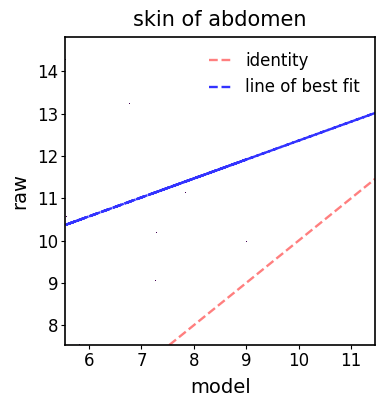

model=SCANVI | metric=cv_cell | n_cells=38:
Mean Absolute Error=6.73,
Pearson correlation=0.04
Spearman correlation=0.06
r^2=-1.93



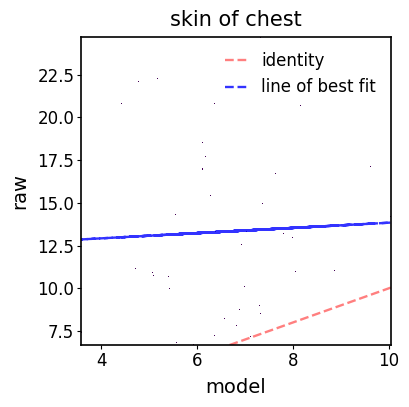

model=SCANVI | metric=cv_cell | n_cells=5:
Mean Absolute Error=12.79,
Pearson correlation=-0.63
Spearman correlation=-0.50
r^2=-12.44



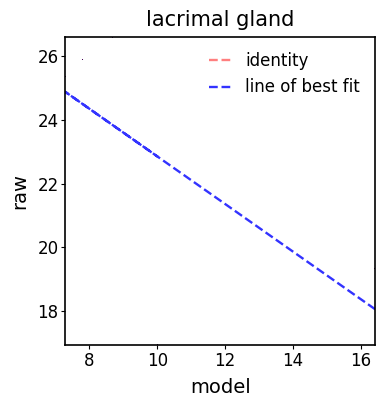

model=SCANVI | metric=cv_cell | n_cells=54:
Mean Absolute Error=3.42,
Pearson correlation=0.41
Spearman correlation=0.36
r^2=-0.70



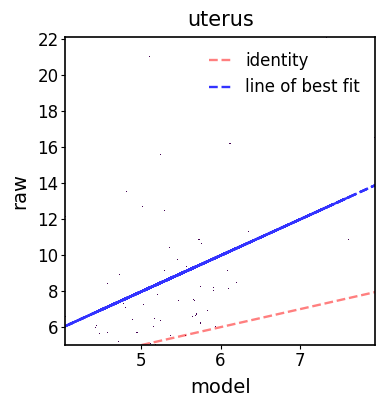

model=SCANVI | metric=cv_cell | n_cells=169:
Mean Absolute Error=5.25,
Pearson correlation=0.17
Spearman correlation=0.24
r^2=-0.85



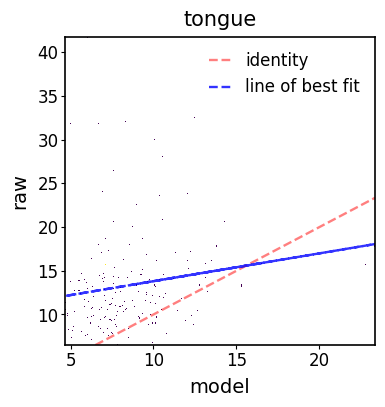

model=SCANVI | metric=cv_cell | n_cells=4158:
Mean Absolute Error=1.83,
Pearson correlation=0.64
Spearman correlation=0.73
r^2=0.30



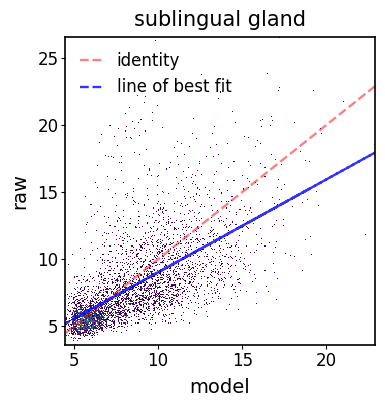

model=SCANVI | metric=cv_cell | n_cells=178:
Mean Absolute Error=2.78,
Pearson correlation=0.08
Spearman correlation=0.15
r^2=-1.00



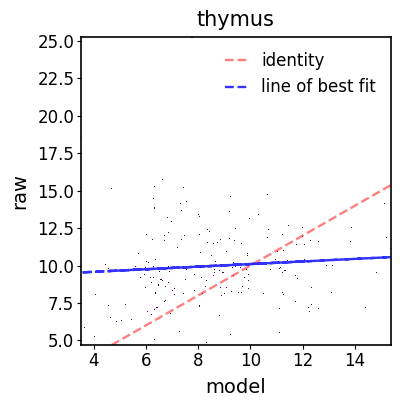

model=SCANVI | metric=cv_cell | n_cells=2940:
Mean Absolute Error=1.88,
Pearson correlation=0.17
Spearman correlation=0.09
r^2=-0.48



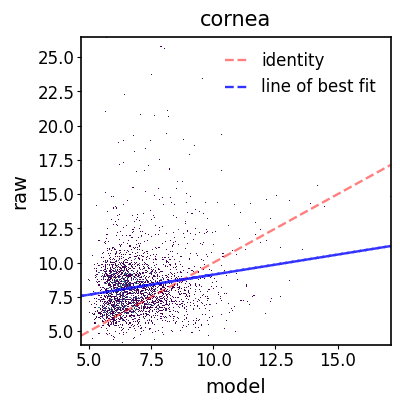

model=SCANVI | metric=cv_cell | n_cells=325:
Mean Absolute Error=3.02,
Pearson correlation=0.23
Spearman correlation=0.25
r^2=-3.67



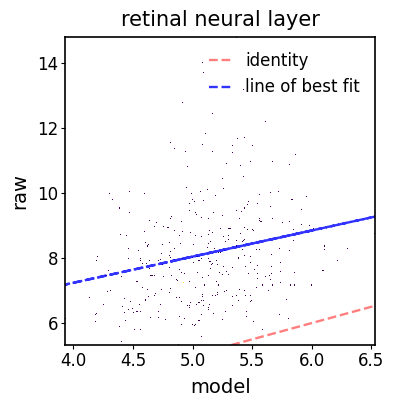

model=SCANVI | metric=cv_cell | n_cells=471:
Mean Absolute Error=1.59,
Pearson correlation=0.26
Spearman correlation=0.28
r^2=-0.09



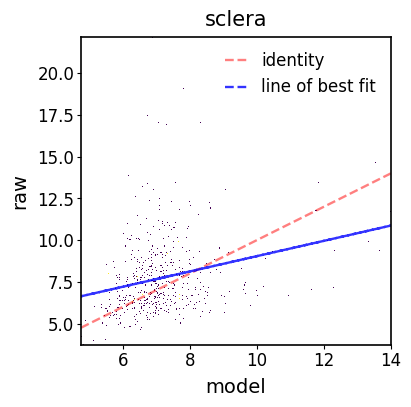

model=SCANVI | metric=cv_cell | n_cells=4151:
Mean Absolute Error=1.30,
Pearson correlation=0.22
Spearman correlation=0.28
r^2=-0.49



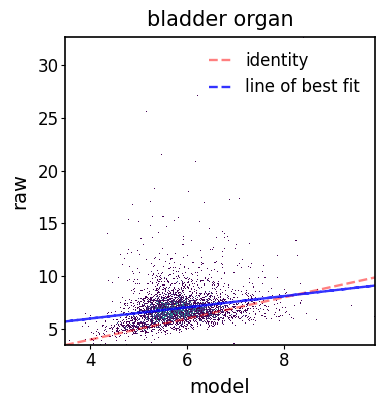

model=SCANVI | metric=cv_cell | n_cells=6220:
Mean Absolute Error=1.94,
Pearson correlation=-0.08
Spearman correlation=0.05
r^2=-0.53



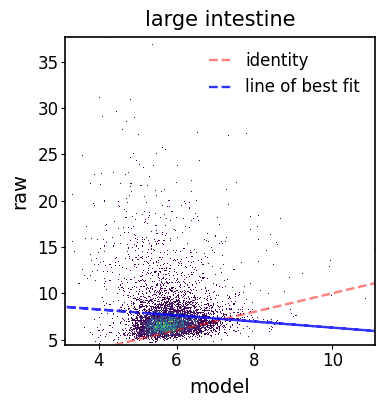

model=SCANVI | metric=cv_cell | n_cells=13981:
Mean Absolute Error=2.24,
Pearson correlation=0.91
Spearman correlation=0.91
r^2=0.82



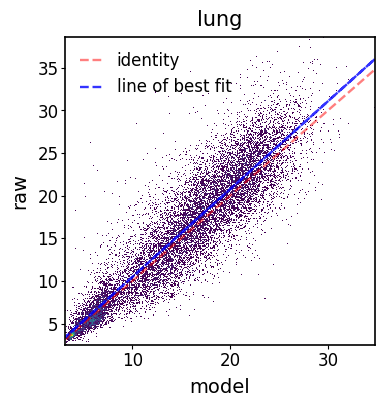

model=SCANVI | metric=cv_cell | n_cells=3712:
Mean Absolute Error=2.92,
Pearson correlation=0.26
Spearman correlation=0.27
r^2=-0.45



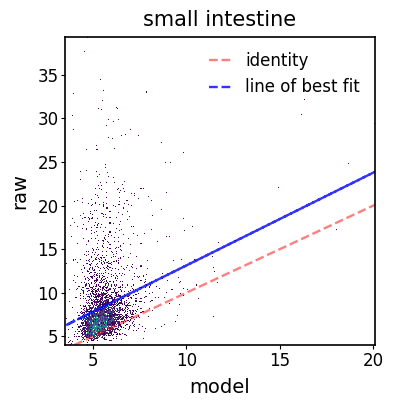

model=SCANVI | metric=cv_cell | n_cells=8331:
Mean Absolute Error=5.21,
Pearson correlation=0.01
Spearman correlation=-0.01
r^2=-2.43



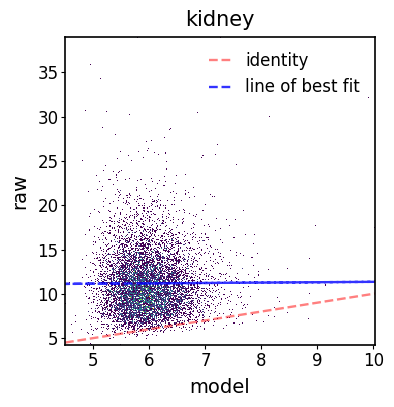

model=SCANVI | metric=cv_cell | n_cells=1087:
Mean Absolute Error=6.81,
Pearson correlation=0.39
Spearman correlation=0.35
r^2=-0.43



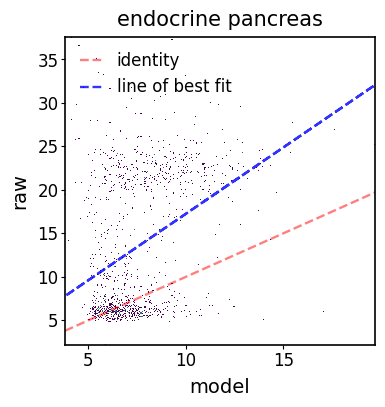

model=SCANVI | metric=cv_cell | n_cells=26:
Mean Absolute Error=2.70,
Pearson correlation=0.07
Spearman correlation=0.08
r^2=-0.66



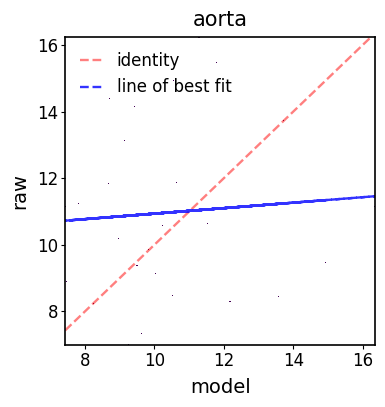

In [ ]:
for tissue in query_model.adata.obs['tissue'].unique():
    ppc_plt = PPCPlot(ppc[tissue])
    ppc_plt.plot_cv(model_name="SCANVI", cell_wise=True, plt_type="hist2d")

    fig_path = f'{temp_fig_dir}/ppc_cv_cell_ts_query_{tissue}.svg'
    plt.savefig(fig_path, dpi=600, bbox_inches="tight")
    plt.title(tissue)
    plt.show()

model=SCANVI | metric=cv_cell | n_cells=90167:
Mean Absolute Error=3.15,
Pearson correlation=0.69
Spearman correlation=0.59
r^2=0.31



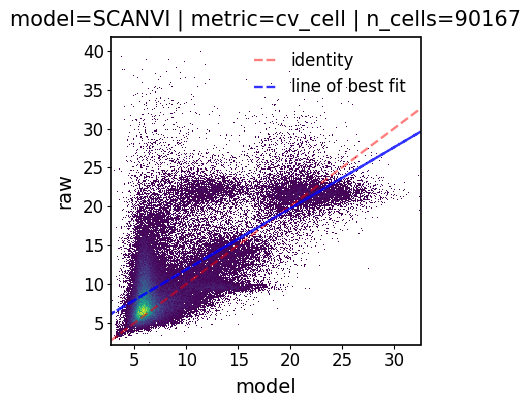

In [ ]:
ppc_nolung = criticism.PosteriorPredictiveCheck(query_model.adata[query_model.adata.obs['tissue']!='lung'], models_dict)
# expected runtime ~8min
ppc_nolung.coefficient_of_variation("features")

ppc_plt = PPCPlot(ppc_nolung)
ppc_plt.plot_cv(model_name="SCANVI", cell_wise=True, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/ppc_cv_cell_ts_query_no_lung.svg'
plt.savefig(fig_path, dpi=600, bbox_inches="tight")

In [ ]:
query_model2 = query_model
query_model2.adata = query_data[query_data.obs['tissue']=='lung']

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


model=SCANVI | metric=cv_cell | n_cells=13981:
Mean Absolute Error=2.23,
Pearson correlation=0.91
Spearman correlation=0.91
r^2=0.83



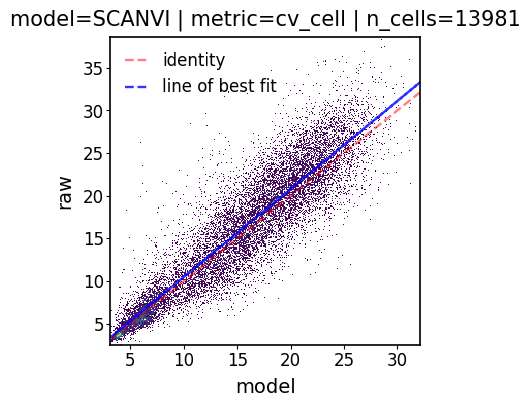

In [ ]:
ppc_lung = criticism.PosteriorPredictiveCheck(query_model2.adata[query_model2.adata.obs['tissue']=='lung'], models_dict)
# expected runtime ~8min
ppc_lung.coefficient_of_variation("features")

ppc_plt_lung = PPCPlot(ppc_lung)
ppc_plt_lung.plot_cv(model_name="SCANVI", cell_wise=True, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/ppc_cv_cell_ts_query_lung.svg'
plt.savefig(fig_path, dpi=600, bbox_inches="tight")

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


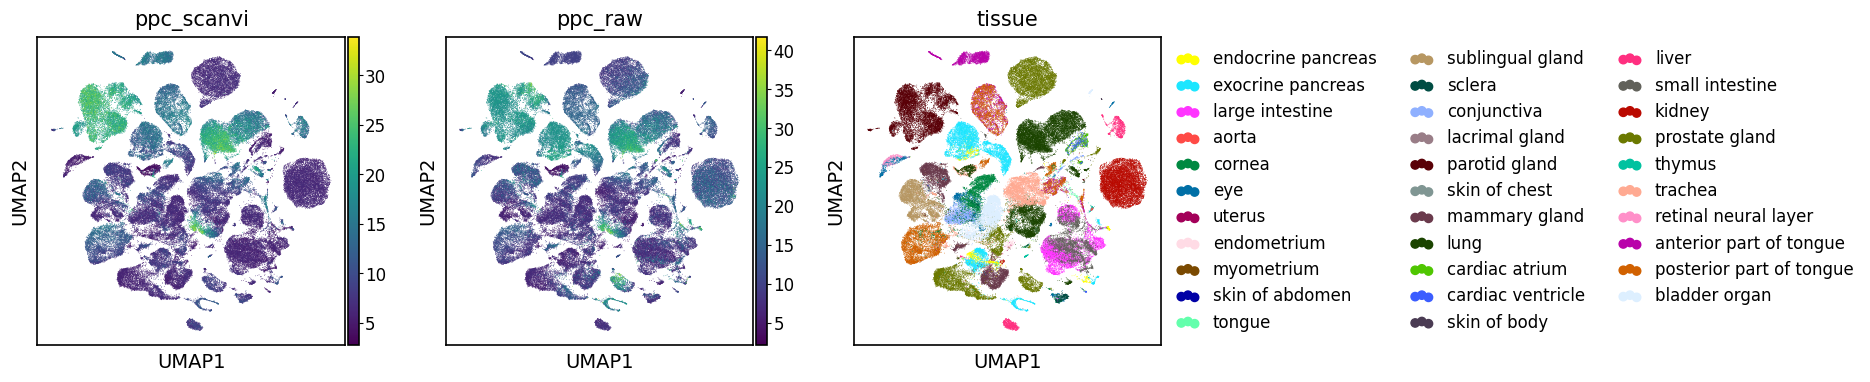

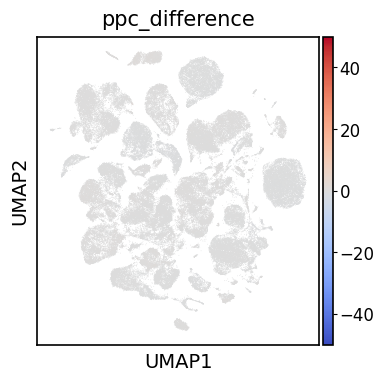

In [ ]:
query_data.obs['ppc_scanvi'] = ppc.metrics['cv_cell']['SCANVI']
query_data.obs['ppc_raw'] = ppc.metrics['cv_cell']['Raw']
query_data.obs['ppc_difference'] = (query_data.obs['ppc_scanvi'] - query_data.obs['ppc_raw']) / query_data.obs['ppc_raw']
sc.pl.umap(query_data, color=['ppc_scanvi', 'ppc_raw', 'tissue'])
sc.pl.umap(query_data, color=['ppc_difference'], color_map='coolwarm', vmax=50, vmin=-50)

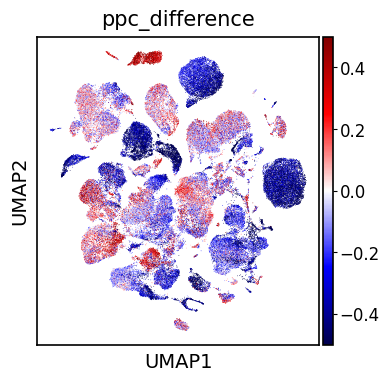

In [ ]:
sc.pl.umap(query_data, color=['ppc_difference'], color_map='seismic', vmax=0.5, vmin=-0.5, sort_order=False)

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


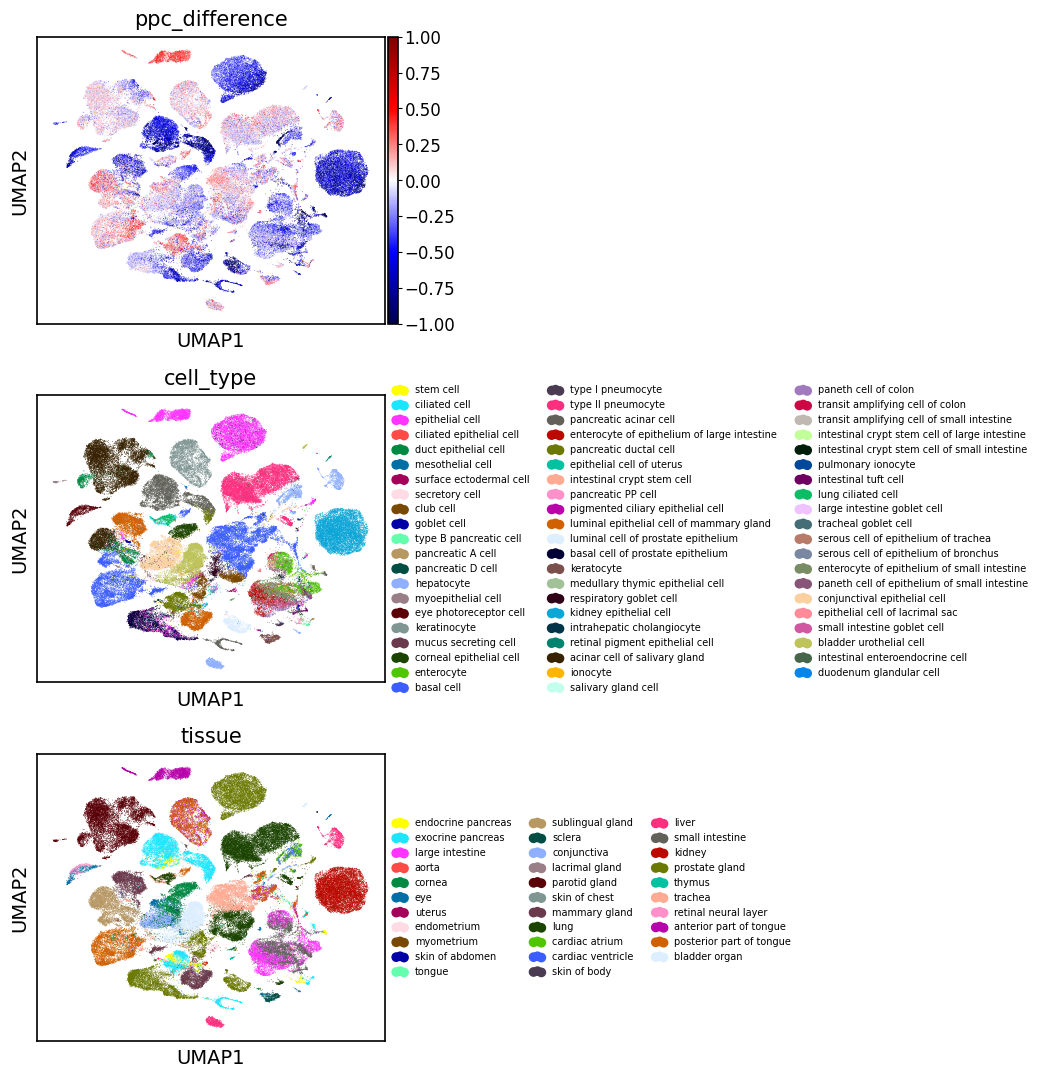

In [ ]:
query_data.obs['ppc_difference'] = np.log(query_data.obs['ppc_scanvi'] / query_data.obs['ppc_raw'])
sc.pl.umap(query_data, color=['ppc_difference', 'cell_type', 'tissue'], color_map='seismic', vmax=1.0, vmin=-1.0, ncols=1, legend_fontsize=7, sort_order=False, save='ppc_cells_ts_epithelial.svg')